## From-Scratch “MiniTorch” — Notebook Overview

In this notebook we will **implement a minimal deep-learning framework from scratch** (“miniTorch”) and use it to train a simple neural network on the **MNIST** dataset as a toy problem.

### Objectives
- **Layers:** Implement core layers (e.g., `Linear`, `Dropout`, `BatchNorm1D`) with clean APIs.
- **Forward & Backward:** Write explicit **forward** and **backward** passes for every layer (no autograd).
- **Losses:** Implement a **cross-entropy from logits** loss.
- **Training Loop:** Build an epoch-based loop with **train/validation** splits and metrics.
- **Optimization:** Perform **manual SGD** parameter updates (learning rate, gradient averaging, etc.).

### Scope & Assumptions
- We will **not** use PyTorch autograd; gradients are computed **manually**.
- Tensors are used only as numerical containers and for basic ops (matmul, sum, etc.).
- We adopt PyTorch-style `net.train()` / `net.eval()` mode switches for realism.
- The dataset is **MNIST** (28×28 grayscale digits, 10 classes), serving as a **toy setting** to validate our implementation.

### What You’ll Get By the End
- A working “miniTorch” stack: layers → forward/backward → training loop → optimizer.
- Clear, student-friendly code that mirrors real libraries while remaining small and inspectable.



## 1. Loading the MNIST Dataset

We will use the **MNIST** dataset — a classic benchmark of **28×28 grayscale images** of handwritten digits (0–9).  
It contains:
- **60,000** training images
- **10,000** test images

### Steps:
1. **Download & Transform**  
   - Use `torchvision.datasets.MNIST` to automatically download the data.
   - Convert images to tensors and normalize pixel values to the range \([-1, 1]\).

2. **Split into Train & Validation**  
   - The official training set (60,000 samples) will be split into:
     - **Training set:** 80% of the data (48,000 images).
     - **Validation set:** 20% of the data (12,000 images).
   - The split allows us to monitor generalization during training.

3. **Test Set**  
   - The test set (10,000 images) is kept separate and **only used at the end** to report final performance.

### Why Split into Validation?
The validation set helps track **overfitting**:  
- If training accuracy keeps increasing but validation accuracy stalls or decreases, the model is memorizing instead of generalizing.

### Summary
- **Training set:** update model weights.
- **Validation set:** tune hyperparameters & monitor generalization.
- **Test set:** final unbiased evaluation.


In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
# pick the seed for reproducibility - change it to explore the effects of random variations
np.random.seed(0)
import random
from tqdm import tqdm
from torch.utils.data import random_split

In [21]:
import torch
import torchvision
import torchvision.transforms as transforms

In [22]:
# Define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load full train dataset
full_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split into train and validation
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

# DataLoaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

# Test data
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [23]:
# Example: Iterate over a few batches
for images, labels in trainloader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


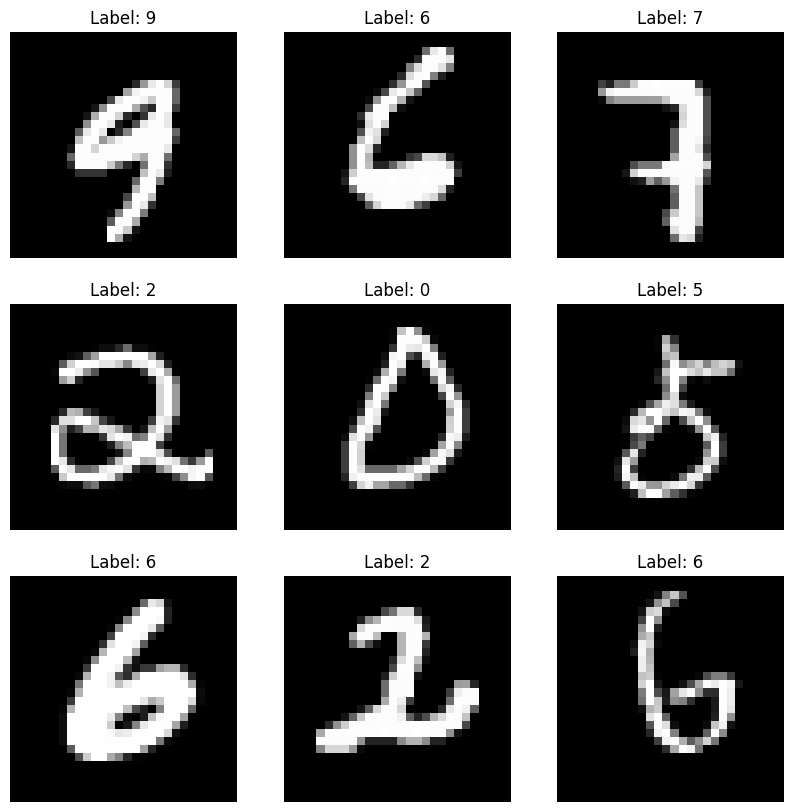

In [24]:
# Check some examples
for images, labels in trainloader:
    # Denormalize the images for plotting
    images = images * 0.5 + 0.5

    # Plot the images
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Plot 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i][0], cmap='gray')  # images[i][0] for grayscale images
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()
    break


## 2. Implementing the Linear Layer

The **Linear** (or fully connected / dense) layer is one of the fundamental building blocks of neural networks.  
It performs a **linear transformation** of the input:

$$
Z = XW + b
$$

- **Forward pass:**  
  Takes the input $X \in \mathbb{R}^{\text{batch} \times n_{\text{in}}}$ and computes the weighted sum using the weight matrix $W \in \mathbb{R}^{n_{\text{in}} \times n_{\text{out}}}$ and bias vector $b \in \mathbb{R}^{n_{\text{out}}}$.
- **Backward pass:**  
  Computes the gradients of the loss with respect to $W$, $b$, and $X$ so we can update the parameters during training.
- **Update step:**  
  Applies a gradient descent step to $W$ and $b$ using the computed gradients and a learning rate.

Below is a template where you will fill in the missing pieces (`# TODO`) to implement forward, backward, and update logic.

In [25]:
class Linear:
    """
    A simple fully connected (dense) layer.
    Performs a linear transformation:  Z = XW + b
    """

    def __init__(self, nin, nout, device="cpu"):
        """
        Initialize the layer parameters.
        """
        # Initialize weights from a normal distribution
        self.W = torch.randn(nin, nout, device=device, requires_grad=False)
        # Initialize biases to zero
        self.b = torch.zeros(nout, device=device, requires_grad=False)
        self.training = True  # for compatibility with Dropout/BatchNorm

    def train(self):
        """Switch to training mode."""
        self.training = True
        return self

    def eval(self):
        """Switch to evaluation mode."""
        self.training = False
        return self

    def forward(self, X):
        """
        Forward pass: compute the output of the layer.
        """
        self.X = X  # store for backward pass
        # TODO: Implement Z = XW + b
        Z = torch.matmul(X, self.W) + self.b
        return Z

    def backward(self, dZ):
        """
        Backward pass: compute gradients w.r.t. W, b, and X.
        """
        # TODO: Compute self.dW, self.db, and self.dX
        batch_size = self.X.size(0)
        self.dW = torch.matmul(self.X.T, dZ) / batch_size
        self.db = torch.sum(dZ, dim=0) / batch_size
        self.dX = torch.matmul(dZ, self.W.T)
        return self.dX

    def update(self, lr):
        """
        Update parameters using gradient descent.
        """
        # TODO: Update W and b using self.dW and self.db
        self.W -= lr * self.dW
        self.b -= lr * self.db


In [26]:

# Example usage
nin = 4
nout = 3
n_batch = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Simulated input tensor
X = torch.randn(n_batch, nin).to(device)

# Create an instance of the Linear class and compute the linear transformation
net = Linear(nin, nout, device=device)
Z = net.forward(X)
print(Z.shape)

torch.Size([5, 3])


## 3. CrossEntropyFromLogits Loss

To train a neural network for **classification**, we need a loss function that measures how well the predicted class scores (logits) match the true labels.  
A very common choice is the **Cross-Entropy Loss**, combined with the **Softmax** function.

### Step 1: Softmax

Given the logits for each sample:
$$
Z \in \mathbb{R}^{m \times C}
$$
where $m$ is the batch size and $C$ is the number of classes,  
the softmax function converts logits into probabilities:

$$
A_{i,j} = \frac{\exp(Z_{i,j})}{\sum_{k=1}^{C} \exp(Z_{i,k})}
$$

This ensures:
- $A_{i,j} \geq 0$ (all outputs are non-negative)
- $\sum_{j=1}^{C} A_{i,j} = 1$ (rows sum to 1, valid probability distribution).

### Step 2: Cross-Entropy Loss

If $Y_i$ is the true label for sample $i$ (an integer in $[0, C-1]$),  
the cross-entropy loss for one sample is:

$$
\ell_i = -\log\big( A_{i, Y_i} \big)
$$

The loss over the batch is the average:

$$
\mathcal{L} = \frac{1}{m} \sum_{i=1}^m \ell_i
= -\frac{1}{m} \sum_{i=1}^m \log\big( A_{i, Y_i} \big)
$$

### Step 3: Gradient (Backward Pass)

The derivative of the loss with respect to the logits is elegant:

$$
\frac{\partial \mathcal{L}}{\partial Z_{i,j}}
= A_{i,j} - \mathbf{1}[j = Y_i]
$$

That is:
- For the correct class: $A_{i,Y_i} - 1$
- For other classes: $A_{i,j}$

This makes backpropagation very efficient.

---

### Summary

- **Forward pass:** compute softmax + cross-entropy.  
- **Backward pass:** subtract 1 from the probability of the true class.  

This loss is standard for multi-class classification problems such as MNIST.

---

We can express this more compactly in **matrix form**.

Let:
- $ A \in \mathbb{R}^{m \times C} $ be the matrix of softmax outputs,  
- $ Y \in \mathbb{R}^{m \times C} $ be the one-hot encoded true labels,  
- $ m $ = batch size.  

Then the gradient of the loss w.r.t. the logits $Z$ is:

$$
\frac{\partial \mathcal{L}}{\partial Z} = \frac{1}{m}\,(A - Y)
$$

---

### Key Points:
- The subtraction $$ A - Y $$ automatically applies the correct rule to all classes in all samples.
- The factor $ \tfrac{1}{m} $ appears if the loss is averaged across the batch (omit it if summing).
- This compact vectorized form makes backpropagation efficient in practice.

In [27]:
class CrossEntropyFromLogits:
    """
    Implements the combination of:
    - Softmax activation (from raw logits)
    - Cross-entropy loss

    This is a common choice for multi-class classification.
    """

    def forward(self, Z, Y):
        """
        Forward pass: compute the cross-entropy loss from raw logits.

        Args:
            Z (torch.Tensor): Logits (unnormalized scores) of shape (batch_size, n_classes).
            Y (torch.Tensor): True class indices of shape (batch_size,).

        Returns:
            loss torch.Tensor: Scalar value of the cross-entropy loss.
        """
        self.Y = Y  # Store true labels for backward pass

        # TODO: Compute softmax probabilities (convert logits to probabilities)
        # self.A = ...
        Z_shifted = Z - torch.max(Z, dim=1, keepdim=True)[0]
        exp_Z = torch.exp(Z_shifted)
        sum_exp_Z = torch.sum(exp_Z, dim=1, keepdim=True)
        self.A = exp_Z / sum_exp_Z

        # TODO: Compute log-softmax (log probabilities)
        # log_softmax_Z = ...
        log_sum_exp = torch.log(sum_exp_Z)
        log_softmax_Z = Z_shifted - log_sum_exp

        # TODO: Select the log-probabilities of the correct classes for each sample
        # log_probs = ...
        log_probs = log_softmax_Z[range(len(Y)), Y]

        # TODO: Cross-entropy loss: average negative log-likelihood
        # loss = ...
        loss = -torch.mean(log_probs)

        return loss

    def backward(self, n_classes):
        """
        Backward pass: compute the gradient of the loss with respect to logits Z.

        Args:
            n_classes (int): Number of classes in the classification problem.

        Returns:
            torch.Tensor: Gradient dZ of shape (batch_size, n_classes).
        """
        batch_size = len(self.Y)
        # TODO: One-hot encode the true labels
        # Y_one_hot = ...
        # Y_one_hot = torch.zeros_like(self.A) # Alternativa
        Y_one_hot = torch.zeros(batch_size, n_classes)
        Y_one_hot[range(batch_size), self.Y] = 1

        # TODO: Derivative of cross-entropy w.r.t logits: softmax_output - one_hot_labels
        # dZ = ...
        dZ = (self.A - Y_one_hot) / batch_size

        return dZ


In [28]:
# Example usage
n_batch = 5
CELoss = CrossEntropyFromLogits()
Y = torch.randint(0, 3, (n_batch,))
loss = CELoss.forward(Z, Y)
print(loss)

tensor(1.2140)


## 4. Training Loop — Forward, Backward, Manual Parameter Updates (No Optimizers Yet)

In this section you’ll complete the **core learning cycle** using only the pieces we’ve built:
1. **Forward pass:** compute logits \(Z\) from inputs \(X\).
2. **Loss:** compute cross-entropy from logits and labels.
3. **Backward (loss):** compute \(dZ = \partial \mathcal{L} / \partial Z\) (vectorized).
4. **Backward (network):** backpropagate \(dZ\) through layers to fill per-parameter grads.
5. **Manual update:** call `net.update(learning_rate)` to apply **plain SGD** updates.

### TODOs (what you must fill in)
- [ ] **Forward:** `Z = net.forward(X)`
- [ ] **Loss:** `loss = CELoss.forward(Z, Y)`
- [ ] **Backward (loss):** `dZ = CELoss.backward(n_classes)`  (matrix form \(A - Y\); include \(1/m\) if you average)
- [ ] **Backward (network):** `net.backward(dZ)`
- [ ] **Update:** `net.update(learning_rate)`  *(manual SGD; no optimizer classes yet)*
- [ ] **Metrics:** accumulate running loss/accuracy for train and val

**Tips**
- Average your **layer gradients** by batch size in each layer (e.g., `dW /= m`) for LR stability.
- Keep **validation/test** forward-only (no `backward`, no `update`).
- If you want to tweak LR per epoch, just modify the variable `learning_rate` before the loop or inside it.

Epoch 1/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 239.66it/s]


Epoch 1/10 | Train Loss: 40.3880 Acc: 0.1072 | Val Loss: 38.9178 Acc: 0.1134


Epoch 2/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 232.89it/s]


Epoch 2/10 | Train Loss: 39.3510 Acc: 0.1087 | Val Loss: 37.9343 Acc: 0.1140


Epoch 3/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 232.26it/s]


Epoch 3/10 | Train Loss: 38.4102 Acc: 0.1111 | Val Loss: 37.0359 Acc: 0.1162


Epoch 4/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 238.51it/s]


Epoch 4/10 | Train Loss: 37.5461 Acc: 0.1128 | Val Loss: 36.2067 Acc: 0.1185


Epoch 5/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 220.81it/s]


Epoch 5/10 | Train Loss: 36.7440 Acc: 0.1143 | Val Loss: 35.4357 Acc: 0.1200


Epoch 6/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 238.84it/s]


Epoch 6/10 | Train Loss: 35.9929 Acc: 0.1155 | Val Loss: 34.7132 Acc: 0.1231


Epoch 7/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 240.12it/s]


Epoch 7/10 | Train Loss: 35.2843 Acc: 0.1174 | Val Loss: 34.0317 Acc: 0.1250


Epoch 8/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 235.94it/s]


Epoch 8/10 | Train Loss: 34.6116 Acc: 0.1191 | Val Loss: 33.3848 Acc: 0.1274


Epoch 9/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 237.48it/s]


Epoch 9/10 | Train Loss: 33.9697 Acc: 0.1199 | Val Loss: 32.7677 Acc: 0.1298


Epoch 10/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 232.00it/s]


Epoch 10/10 | Train Loss: 33.3548 Acc: 0.1215 | Val Loss: 32.1768 Acc: 0.1317


[Test]: 100%|██████████| 157/157 [00:00<00:00, 241.21it/s]


[Test] Loss: 32.9043 | Acc: 0.1243


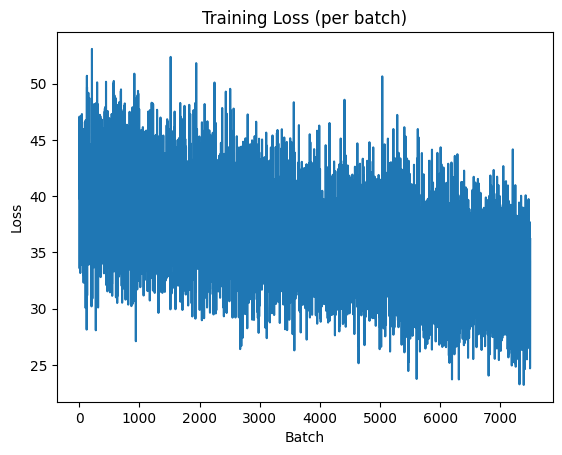

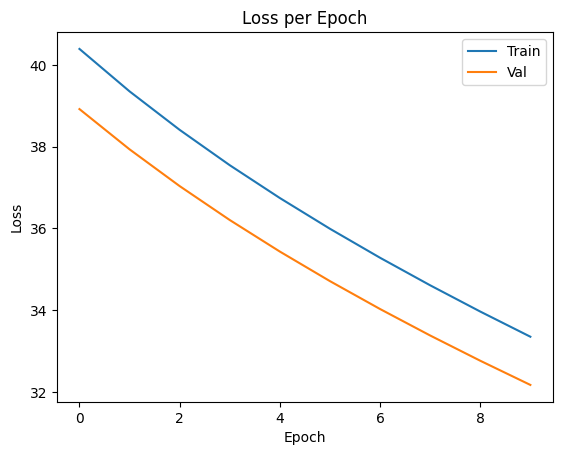

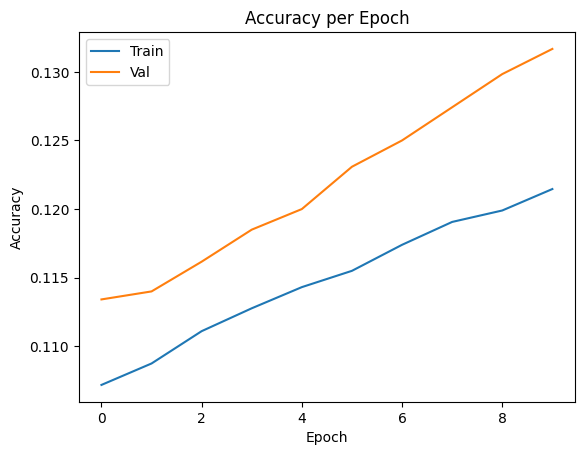

In [29]:
num_epochs = 10
learning_rate = 0.001
nin = 28 * 28  # for MNIST images (28x28)
n_classes = 10 # for MNIST (digits 0-9)

# Create an instance of the Linear class and compute the linear transformation
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = Linear(nin, n_classes, device=device)

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
batch_losses = []  # per-batch losses for the plot

for epoch in range(1, num_epochs + 1):
    # -------- TRAIN --------
    if hasattr(net, "train"): net.train()
    running_loss, tot_correct, tot_samples = 0.0, 0, 0
    total_batches = len(trainloader)

    pbar = tqdm(trainloader, desc=f"Epoch {epoch}/{num_epochs} [Train]")
    for batch_idx, (images, labels) in enumerate(pbar, 1):
        X = images.view(images.size(0), -1).to(device)
        Y = labels.to(device)

        # Forward
        Z = Z = net.forward(X) #TODO
        loss = CELoss.forward(Z, Y) #TODO

        # Backward + update (manual autograd)
        dZ = CELoss.backward(n_classes)  # TODO
        _ = net.backward(dZ)  # TODO
        net.update(learning_rate)  # TODO



        # Stats
        running_loss += loss.item() #TODO
        batch_losses.append(loss.detach().cpu().item())
        _, predicted = torch.max(Z, 1)
        tot_correct += (predicted == Y).sum().item()
        tot_samples += Y.size(0)

        if batch_idx % max(1, total_batches // 10) == 0:
            pbar.set_postfix(loss=f"{loss.item():.4f}",
                             acc=f"{tot_correct / max(1, tot_samples):.4f}")

    train_loss = running_loss / len(trainloader)  # TODO
    train_acc = tot_correct / tot_samples  # TODO

    # -------- VALIDATION --------
    if hasattr(net, "eval"): net.eval()
    val_running_loss, val_correct, val_samples = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(valloader, desc=f"Epoch {epoch}/{num_epochs} [Val]"):
            X = images.view(images.size(0), -1).to(device)
            Y = labels.to(device)

            Z = net.forward(X)  # TODO
            vloss = CELoss.forward(Z, Y)  # TODO
            val_running_loss += vloss.item()  # TODO

            _, predicted = torch.max(Z, 1)
            val_correct += (predicted == Y).sum().item()
            val_samples += Y.size(0)

    val_loss = val_running_loss / len(valloader)
    val_acc = val_correct / val_samples

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

# -------- OPTIONAL TEST --------
if 'testloader' in globals() and testloader is not None:
    if hasattr(net, "eval"): net.eval()
    test_correct, test_samples, test_running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in tqdm(testloader, desc="[Test]"):
            X = images.view(images.size(0), -1).to(device)
            Y = labels.to(device)
            Z = net.forward(X) #TODO
            loss = CELoss.forward(Z, Y)#TODO
            test_running_loss += loss.item() #TODO
            _, pred = torch.max(Z, 1)
            test_correct += (pred == Y).sum().item()
            test_samples += Y.size(0)
    test_loss = test_running_loss / len(testloader)
    test_acc = test_correct / test_samples
    print(f"[Test] Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")

# -------- PLOTS --------
plt.figure(); plt.plot(np.array(batch_losses))
plt.xlabel('Batch'); plt.ylabel('Loss'); plt.title('Training Loss (per batch)'); plt.show()

plt.figure(); plt.plot(history["train_loss"], label='Train'); plt.plot(history["val_loss"], label='Val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss per Epoch'); plt.show()

plt.figure(); plt.plot(history["train_acc"], label='Train'); plt.plot(history["val_acc"], label='Val')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy per Epoch'); plt.show()

## The `Net` Class: A Simple Sequential Container

To organize our neural network, we define a `Net` class that acts as a **sequential container of layers**.  
This class is inspired by frameworks like PyTorch, but implemented from scratch for educational purposes.

### Key Responsibilities

- **Layer Management:**  
  We can add layers (e.g., `Linear`, `ReLU`, `Dropout`) using `add()`.  
  Each layer must implement:
  - `forward()` — computes the output given inputs.  
  - `backward()` — computes the gradients of the loss w.r.t. its inputs.  
  - `update(lr)` — updates the trainable parameters (if any).  

- **Training/Evaluation Modes:**  
  The class has `train()` and `eval()` methods.  
  These switch the whole network into training or evaluation mode, propagating the setting to layers that support it (like `Dropout`, which behaves differently during training vs evaluation).

- **Forward and Backward Passes:**  
  - `forward(X)` runs the input through all layers in sequence.  
  - `backward(dZ)` propagates gradients in reverse order, from the output back to the input.  

- **Parameter Updates:**  
  `update(lr)` applies gradient descent to all trainable layers, using the provided learning rate.  
  (Later we could replace this with more advanced optimizers like Adam or RMSProp.)

### Next Steps

- **TODOs:**  
  - Implement the details of each layer’s `forward()` and `backward()` functions.  
  - Add parameter updates inside `update()` for layers that have weights.  
  - Complete the training loop that uses this `Net` container to build and train a model on MNIST.  

This design provides a clear and modular structure, making it easy to extend with new layers or optimizers.

In [30]:
class Net:
    """
    A simple sequential container for custom layers.
    Provides PyTorch-like train()/eval() switches and
    runs forward/backward/update across all layers.
    """
 
    def __init__(self):
        """
        Start with an empty list of layers and set the network
        to training mode by default.
        """
        self.layers = []
        self.training = True  # True = training mode, False = eval mode
 
    def add(self, layer):
        """
        Add a layer to the network.
 
        Args:
            layer: Any object that implements forward(), backward(), update(),
                   and (optionally) train()/eval() for mode control.
        """
        self.layers.append(layer)
 
    # ---- Mode control (pro-style) ----
    def train(self):
        """
        Switch the whole network to training mode and propagate
        the setting to layers that implement train().
        """
        self.training = True
        for layer in self.layers:
            if hasattr(layer, "train"):
                layer.train()
        return self
 
    def eval(self):
        """
        Switch the whole network to evaluation mode and propagate
        the setting to layers that implement eval().
        """
        self.training = False
        for layer in self.layers:
            if hasattr(layer, "eval"):
                layer.eval()
        return self
 
    # ---- Core passes ----
    def forward(self, X):
        """
        Forward pass through all layers.
 
        Args:
            X (torch.Tensor): Input to the network.
 
        Returns:
            torch.Tensor: Output after the last layer.
        """
        for layer in self.layers:
            #Implement the forward pass
            X = layer.forward(X)  # TODO  # output of one layer becomes input to the next
        return X
 
    def backward(self, dZ):
        """
        Backward pass through all layers in reverse order.
 
        Args:
            dZ (torch.Tensor): Gradient of the loss w.r.t. network output.
 
        Returns:
            torch.Tensor: Gradient of the loss w.r.t. the network input.
        """
        for layer in reversed(self.layers):
            #Implement the backward pass
            dZ = layer.backward(dZ)  # TODO  # each layer returns grad for the previous one
        return dZ
 
    def update(self, lr):
        """
        Update parameters of all trainable layers with the given learning rate.
 
        Args:
            lr (float): Learning rate.
        """
        for layer in self.layers:
            # Some layers (e.g., activations) may not have parameters
            if hasattr(layer, "update"):
                layer.update(lr)

### Testing the Implementation

The following cells are intended as a **first test** of the network implementation.  
We build a simple architecture with two linear layers and train it using our custom  
cross-entropy loss. Since we have not yet introduced any **non-linear activation functions**,  
this setup is equivalent to a **softmax regression model** (a linear classifier).  

The purpose here is to verify that the forward pass, backward pass, parameter updates,  
and loss tracking are working correctly before moving on to more complex networks.

In [31]:
# Check if CUDA is available and set the device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Forcing the device to CPU (this line will override the previous check)
device = 'cpu'

# Define the number of input features and output classes
n_features = 784
n_classes = 10
num_epochs = 10

# Initialize the network (assuming `Net` is a custom class that you've defined)
net = Net()

# Add a linear layer to the network with 784 input features and 1024 output features
net.add(Linear(n_features, 1024, device=device))

# Add another linear layer with 1024 input features and 10 output features
net.add(Linear(1024, n_classes, device=device))

# Initialize the custom cross-entropy loss function from logits
CEloss = CrossEntropyFromLogits()

Epoch 1/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 209.73it/s]


Epoch 1/10 | Train Loss: 723.2033 Acc: 0.1071 | Val Loss: 553.8032 Acc: 0.1308


Epoch 2/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 211.65it/s]


Epoch 2/10 | Train Loss: 497.8126 Acc: 0.1587 | Val Loss: 449.7809 Acc: 0.1860


Epoch 3/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 206.47it/s]


Epoch 3/10 | Train Loss: 407.5870 Acc: 0.2162 | Val Loss: 371.9877 Acc: 0.2510


Epoch 4/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 210.17it/s]


Epoch 4/10 | Train Loss: 340.0035 Acc: 0.2757 | Val Loss: 314.0089 Acc: 0.3058


Epoch 5/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 206.51it/s]


Epoch 5/10 | Train Loss: 289.4347 Acc: 0.3294 | Val Loss: 270.3391 Acc: 0.3567


Epoch 6/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 209.92it/s]


Epoch 6/10 | Train Loss: 251.1783 Acc: 0.3783 | Val Loss: 236.6009 Acc: 0.4006


Epoch 7/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 207.87it/s]


Epoch 7/10 | Train Loss: 221.6928 Acc: 0.4210 | Val Loss: 210.4856 Acc: 0.4366


Epoch 8/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 208.19it/s]


Epoch 8/10 | Train Loss: 198.5640 Acc: 0.4571 | Val Loss: 189.8269 Acc: 0.4733


Epoch 9/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 208.96it/s]


Epoch 9/10 | Train Loss: 180.1916 Acc: 0.4904 | Val Loss: 173.4055 Acc: 0.5042


Epoch 10/10 [Val]: 100%|██████████| 188/188 [00:01<00:00, 183.82it/s]


Epoch 10/10 | Train Loss: 165.2994 Acc: 0.5175 | Val Loss: 159.9282 Acc: 0.5304


[Test]: 100%|██████████| 157/157 [00:00<00:00, 215.18it/s]


[Test] Loss: 155.4689 | Acc: 0.5320


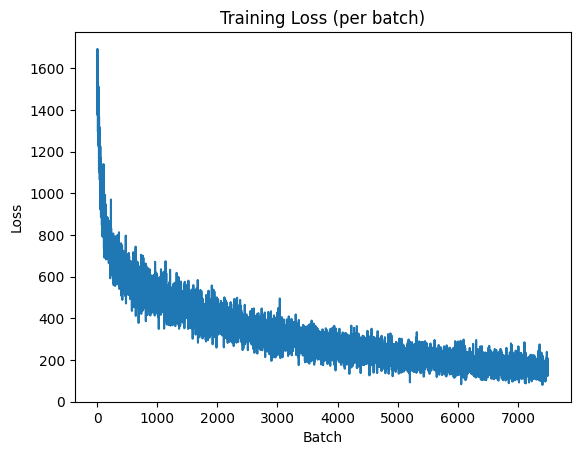

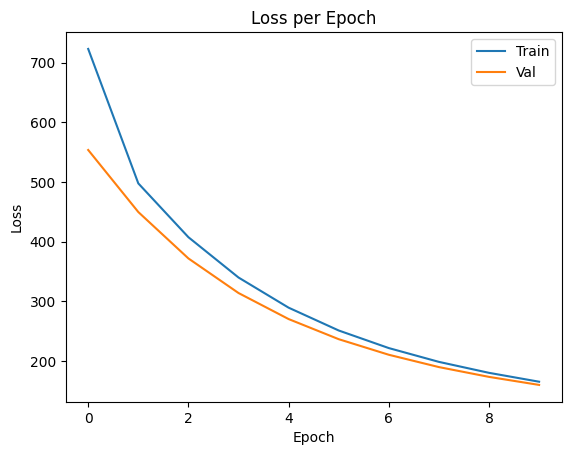

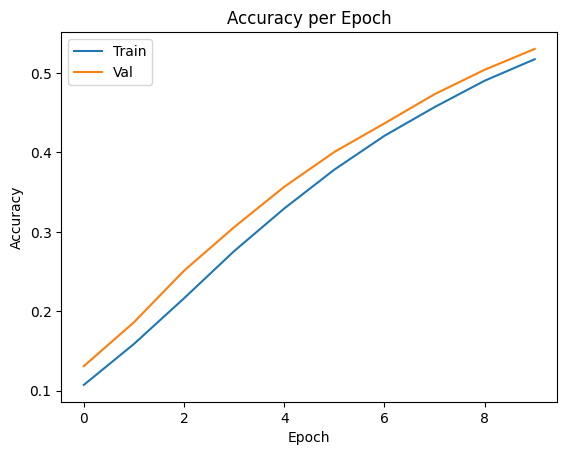

In [32]:
# Set the learning rate
learning_rate = 0.001
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
batch_losses = []  # per-batch losses for the plot

for epoch in range(1, num_epochs + 1):
    # -------- TRAIN --------
    if hasattr(net, "train"): net.train()
    running_loss, tot_correct, tot_samples = 0.0, 0, 0
    total_batches = len(trainloader)

    pbar = tqdm(trainloader, desc=f"Epoch {epoch}/{num_epochs} [Train]")
    for batch_idx, (images, labels) in enumerate(pbar, 1):
        X = images.view(images.size(0), -1).to(device)
        Y = labels.to(device)

        # Forward
        Z = net.forward(X)
        loss = CELoss.forward(Z, Y)

        # Backward + update (manual autograd)
        dZ = CELoss.backward(n_classes)
        _ = net.backward(dZ)
        net.update(learning_rate)

        # Stats
        running_loss += loss.item()
        batch_losses.append(loss.detach().cpu().item())
        _, predicted = torch.max(Z, 1)
        tot_correct += (predicted == Y).sum().item()
        tot_samples += Y.size(0)

        if batch_idx % max(1, total_batches // 10) == 0:
            pbar.set_postfix(loss=f"{loss.item():.4f}",
                             acc=f"{tot_correct / max(1, tot_samples):.4f}")

    train_loss = running_loss / total_batches
    train_acc = tot_correct / tot_samples

    # -------- VALIDATION --------
    if hasattr(net, "eval"): net.eval()
    val_running_loss, val_correct, val_samples = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(valloader, desc=f"Epoch {epoch}/{num_epochs} [Val]"):
            X = images.view(images.size(0), -1).to(device)
            Y = labels.to(device)

            Z = net.forward(X)
            vloss = CELoss.forward(Z, Y)
            val_running_loss += vloss.item()

            _, predicted = torch.max(Z, 1)
            val_correct += (predicted == Y).sum().item()
            val_samples += Y.size(0)

    val_loss = val_running_loss / len(valloader)
    val_acc = val_correct / val_samples

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

# -------- OPTIONAL TEST --------
if 'testloader' in globals() and testloader is not None:
    if hasattr(net, "eval"): net.eval()
    test_correct, test_samples, test_running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in tqdm(testloader, desc="[Test]"):
            X = images.view(images.size(0), -1).to(device)
            Y = labels.to(device)
            Z = net.forward(X)
            loss = CELoss.forward(Z, Y)
            test_running_loss += loss.item()
            _, pred = torch.max(Z, 1)
            test_correct += (pred == Y).sum().item()
            test_samples += Y.size(0)
    test_loss = test_running_loss / len(testloader)
    test_acc = test_correct / test_samples
    print(f"[Test] Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")

# -------- PLOTS --------
plt.figure(); plt.plot(np.array(batch_losses))
plt.xlabel('Batch'); plt.ylabel('Loss'); plt.title('Training Loss (per batch)'); plt.show()

plt.figure(); plt.plot(history["train_loss"], label='Train'); plt.plot(history["val_loss"], label='Val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss per Epoch'); plt.show()

plt.figure(); plt.plot(history["train_acc"], label='Train'); plt.plot(history["val_acc"], label='Val')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy per Epoch'); plt.show()

### ReLU Activation Layer

The **Rectified Linear Unit (ReLU)** is one of the most widely used activation functions in deep learning.  
It introduces **non-linearity** into the network by applying a simple element-wise rule:

$$
a = \text{ReLU}(z) = \max(0, z)
$$

- **Forward Pass**:  
  Each element of the input tensor \( Z \) is mapped to itself if it is positive, or zero if it is negative.  
  This helps prevent the "squashing" effect of sigmoid/tanh and allows gradients to flow more effectively.

- **Backward Pass**:  
  The gradient is passed unchanged for inputs greater than zero and is set to zero for inputs less than or equal to zero:

  $$
  \frac{\partial a}{\partial z} =
  \begin{cases}
  1 & \text{if } z > 0 \\
  0 & \text{if } z \leq 0
  \end{cases}
  $$

- **Update Step**:  
  ReLU has no trainable parameters, so its `update()` method is left empty.

This layer is essential because it allows neural networks to model complex non-linear decision boundaries while remaining computationally efficient.


In [33]:
class ReLU:
    """
    ReLU activation layer.
    """

    def forward(self, Z):
        """
        Perform the forward pass of the ReLU activation function.

        Args:
            Z (torch.Tensor): Input tensor.

        Returns:
            A torch.Tensor: Output tensor with ReLU applied element-wise.
        """
        self.A = torch.maximum(Z, torch.zeros_like(Z)) #TODO
        return self.A

    def backward(self, dA):
        """
        Perform the backward pass of the ReLU activation function.

        Args:
            dA (torch.Tensor): Gradient of the loss with respect to the output.

        Returns:
            dZ torch.Tensor: Gradient of the loss with respect to the input.
        """
        dZ = dA * (self.A > 0).float() #TODO

        return dZ

    def update(self,lr):
        """
        ReLU does not have any parameters to update.
        """
        pass


In [34]:
# Check if CUDA is available and set the device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Forcing the device to CPU (this line will override the previous check)
device = 'cpu'

# Define the number of input features and output classes
n_features = 784
n_classes = 10

# Initialize the network (assuming `Net` is a custom class that you've defined)
net = Net()

# Add a linear layer to the network with 784 input features and 1024 output features
net.add(Linear(n_features, 1024, device=device))

# Add a non-linear activation function
net.add(ReLU())

# Add another linear layer with 1024 input features and 10 output features
net.add(Linear(1024, n_classes, device=device))

# Initialize the custom cross-entropy loss function from logits
CEloss = CrossEntropyFromLogits()

Epoch 1/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 206.01it/s]


Epoch 1/10 | Train Loss: 542.5073 Acc: 0.1152 | Val Loss: 433.8351 Acc: 0.1317


Epoch 2/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 202.29it/s]


Epoch 2/10 | Train Loss: 385.6458 Acc: 0.1418 | Val Loss: 351.0911 Acc: 0.1582


Epoch 3/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 205.59it/s]


Epoch 3/10 | Train Loss: 324.8139 Acc: 0.1744 | Val Loss: 301.5553 Acc: 0.1948


Epoch 4/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 209.70it/s]


Epoch 4/10 | Train Loss: 280.0701 Acc: 0.2148 | Val Loss: 261.4061 Acc: 0.2383


Epoch 5/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 203.01it/s]


Epoch 5/10 | Train Loss: 243.8190 Acc: 0.2583 | Val Loss: 228.9979 Acc: 0.2817


Epoch 6/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 203.47it/s]


Epoch 6/10 | Train Loss: 214.8637 Acc: 0.3013 | Val Loss: 203.4132 Acc: 0.3220


Epoch 7/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 209.16it/s]


Epoch 7/10 | Train Loss: 191.9814 Acc: 0.3405 | Val Loss: 183.3191 Acc: 0.3647


Epoch 8/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 206.13it/s]


Epoch 8/10 | Train Loss: 173.7299 Acc: 0.3771 | Val Loss: 167.2904 Acc: 0.3992


Epoch 9/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 207.23it/s]


Epoch 9/10 | Train Loss: 158.9981 Acc: 0.4091 | Val Loss: 154.2188 Acc: 0.4273


Epoch 10/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 208.61it/s]


Epoch 10/10 | Train Loss: 146.9281 Acc: 0.4379 | Val Loss: 143.3658 Acc: 0.4518


[Test]: 100%|██████████| 157/157 [00:00<00:00, 215.71it/s]

[Test] Loss: 141.5435 | Acc: 0.4525


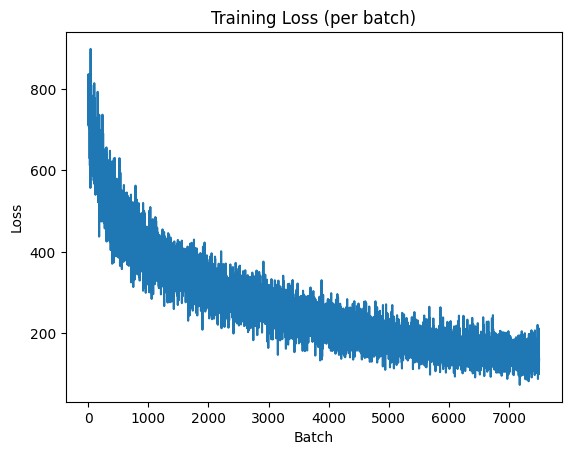

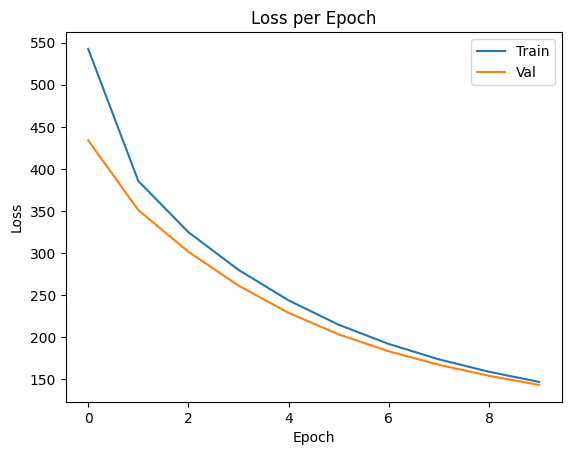

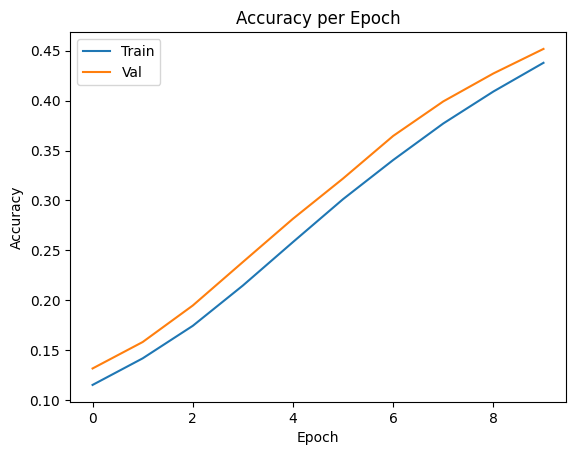

In [35]:
# Set the learning rate
learning_rate = 0.001
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
batch_losses = []  # per-batch losses for the plot

for epoch in range(1, num_epochs + 1):
    # -------- TRAIN --------
    if hasattr(net, "train"): net.train()
    running_loss, tot_correct, tot_samples = 0.0, 0, 0
    total_batches = len(trainloader)

    pbar = tqdm(trainloader, desc=f"Epoch {epoch}/{num_epochs} [Train]")
    for batch_idx, (images, labels) in enumerate(pbar, 1):
        X = images.view(images.size(0), -1).to(device)
        Y = labels.to(device)

        # Forward
        Z = net.forward(X)
        loss = CELoss.forward(Z, Y)

        # Backward + update (manual autograd)
        dZ = CELoss.backward(n_classes)
        _ = net.backward(dZ)
        net.update(learning_rate)

        # Stats
        running_loss += loss.item()
        batch_losses.append(loss.detach().cpu().item())
        _, predicted = torch.max(Z, 1)
        tot_correct += (predicted == Y).sum().item()
        tot_samples += Y.size(0)

        if batch_idx % max(1, total_batches // 10) == 0:
            pbar.set_postfix(loss=f"{loss.item():.4f}",
                             acc=f"{tot_correct / max(1, tot_samples):.4f}")

    train_loss = running_loss / total_batches
    train_acc = tot_correct / tot_samples

    # -------- VALIDATION --------
    if hasattr(net, "eval"): net.eval()
    val_running_loss, val_correct, val_samples = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(valloader, desc=f"Epoch {epoch}/{num_epochs} [Val]"):
            X = images.view(images.size(0), -1).to(device)
            Y = labels.to(device)

            Z = net.forward(X)
            vloss = CELoss.forward(Z, Y)
            val_running_loss += vloss.item()

            _, predicted = torch.max(Z, 1)
            val_correct += (predicted == Y).sum().item()
            val_samples += Y.size(0)

    val_loss = val_running_loss / len(valloader)
    val_acc = val_correct / val_samples

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

# -------- OPTIONAL TEST --------
if 'testloader' in globals() and testloader is not None:
    if hasattr(net, "eval"): net.eval()
    test_correct, test_samples, test_running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in tqdm(testloader, desc="[Test]"):
            X = images.view(images.size(0), -1).to(device)
            Y = labels.to(device)
            Z = net.forward(X)
            loss = CELoss.forward(Z, Y)
            test_running_loss += loss.item()
            _, pred = torch.max(Z, 1)
            test_correct += (pred == Y).sum().item()
            test_samples += Y.size(0)
    test_loss = test_running_loss / len(testloader)
    test_acc = test_correct / test_samples
    print(f"[Test] Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")

# -------- PLOTS --------
plt.figure(); plt.plot(np.array(batch_losses))
plt.xlabel('Batch'); plt.ylabel('Loss'); plt.title('Training Loss (per batch)'); plt.show()

plt.figure(); plt.plot(history["train_loss"], label='Train'); plt.plot(history["val_loss"], label='Val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss per Epoch'); plt.show()

plt.figure(); plt.plot(history["train_acc"], label='Train'); plt.plot(history["val_acc"], label='Val')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy per Epoch'); plt.show()

### Extending the Neural Network

At this point, we have implemented the essential components of a neural network:  
- **Linear transformations (fully connected layers)** to project data into new spaces,  
- **Non-linear activation functions** such as ReLU to introduce complexity and allow the network to model non-linear relationships, and  
- **A cost function (e.g., Cross-Entropy)** to measure the discrepancy between predictions and true labels.  

While this setup already allows us to train a functional neural network, more advanced operations can significantly improve performance and generalization. Two of the most important techniques are:  

- **Dropout**: Randomly disables a fraction of neurons during training, preventing co-adaptation and reducing overfitting.  
- **Batch Normalization**: Normalizes intermediate activations across a mini-batch, stabilizing training and often accelerating convergence.  

Adding these operations will bring our implementation closer to modern deep learning practices, making the models both more robust and efficient.


### Batch Normalization

Batch Normalization (BN) is used to stabilize and accelerate training by normalizing activations.  
Given input activations $X \in \mathbb{R}^{m \times d}$ (batch size $m$, features $d$):

---

**Training mode**

Batch statistics:  
$$
\mu_{\mathrm{B}}=\frac{1}{m}\sum_{i=1}^m X_i
$$  
$$
\sigma^2_{\mathrm{B}}=\frac{1}{m}\sum_{i=1}^m \left(X_i-\mu_{\mathrm{B}}\right)^2
$$

Normalize, then scale/shift:  
$$
\hat{X}_i=\frac{X_i-\mu_{\mathrm{B}}}{\sqrt{\sigma^2_{\mathrm{B}}+\varepsilon}}
$$  
$$
Y_i=\gamma\,\hat{X}_i+\beta
$$

Update running (EMA) statistics with momentum $\alpha$:  
$$
\mu_{\mathrm{R}} \leftarrow (1-\alpha)\,\mu_{\mathrm{R}} + \alpha\,\mu_{\mathrm{B}}
$$  
$$
\sigma^2_{\mathrm{R}} \leftarrow (1-\alpha)\,\sigma^2_{\mathrm{R}} + \alpha\,\sigma^2_{\mathrm{B}}
$$

---

**Inference mode**

Use stored running statistics (no updates):  
$$
\hat{X}_i=\frac{X_i-\mu_{\mathrm{R}}}{\sqrt{\sigma^2_{\mathrm{R}}+\varepsilon}}
$$  
$$
Y_i=\gamma\,\hat{X}_i+\beta
$$

---

**Summary:**  
- **Training:** use $(\mu_{\mathrm{B}}, \sigma^2_{\mathrm{B}})$, normalize, scale/shift, update $(\mu_{\mathrm{R}}, \sigma^2_{\mathrm{R}})$.  
- **Inference:** use $(\mu_{\mathrm{R}}, \sigma^2_{\mathrm{R}})$ collected during training, normalize, scale/shift, **no updates**.

---

### Task

Implement **BatchNorm as a class** with the following:

- **Forward pass (`forward`)**  
  - #TODO compute batch mean $\mu_{\mathrm{B}}$ and variance $\sigma^2_{\mathrm{B}}$ (training)  
  - #TODO normalize input $X$  
  - #TODO scale and shift using $\gamma, \beta$  
  - #TODO update running mean/variance (training only)  
  - #TODO use running statistics in inference mode  

- **Backward pass (`backward`)**  
  - #TODO compute gradient of loss w.r.t. $\hat{X}$  
  - #TODO propagate through normalization to get $dX$  
  - #TODO compute gradients w.r.t. parameters $\gamma, \beta$  

- **Update parameters (`update`)**  
  - #TODO update $\gamma, \beta$ using the learning rate


In [36]:
class BatchNorm1D:
    """
    Batch Normalization for 2D inputs: (batch, features).
 
    TRAIN: compute batch stats, normalize, update running stats, support backward().
    EVAL:  use running stats, no updates, typically no backward().
    """
 
    def __init__(self, n_features, eps=1e-5, momentum=0.1, device="cpu"):
        self.eps = eps
        self.momentum = momentum
        self.device = device
 
        # Learnable affine parameters
        self.gamma = torch.ones(n_features, device=device, requires_grad=False)
        self.beta  = torch.zeros(n_features, device=device, requires_grad=False)
 
        # Running (inference) statistics
        self.running_mean = torch.zeros(n_features, device=device, requires_grad=False)
        self.running_var  = torch.ones(n_features,  device=device, requires_grad=False)
 
        # Mode flag
        self.training = True
 
        # Caches for backward
        self.X = None
        self.X_hat = None
        self.batch_mean = None
        self.batch_var = None
        self.std = None
 
        # Grads for parameters
        self.dgamma = None
        self.dbeta  = None
 
    def train(self): self.training = True;  return self
    def eval(self):  self.training = False; return self
 
    def forward(self, X):
        """
        Args:
            X: (batch, features)
        Returns:
            Y: (batch, features)
        """
        if self.training:
            # ===== TODO: compute batch statistics along batch dim =====
            self.batch_mean = torch.mean(X, dim=0)
            self.batch_var = torch.var(X, dim=0, unbiased=False)   # use unbiased=False
            # ===== TODO: compute std and normalized activations =====
            self.std = torch.sqrt(self.batch_var + self.eps)
            self.X_hat = (X - self.batch_mean) / self.std
            #
            # ===== TODO: update running stats (EMA) =====
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * self.batch_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * self.batch_var
        else:
            # ===== TODO: inference normalization using running stats =====
            self.std = torch.sqrt(self.running_var + self.eps)
            self.X_hat = (X - self.running_mean) / self.std
 
        # Cache input for backward
        self.X = X
 
        # ===== TODO: affine transform Y = gamma * X_hat + beta =====
        Y = self.gamma * self.X_hat + self.beta
        return Y
 
    def backward(self, dY):
        """
        Args:
            dY: upstream gradient (batch, features)
        Returns:
            dX: gradient wrt input X (batch, features)
        """
        if not self.training:
            # In this teaching framework we forbid backward in eval to emphasize the distinction.
            raise RuntimeError("Backward called in eval() mode. Use training mode for gradient computation.")
 
        m = dY.size(0)  # batch size
 
        # ===== TODO: parameter gradients =====
        self.dgamma = torch.sum(dY * self.X_hat, dim=0)
        self.dbeta  = torch.sum(dY, dim=0)
 
        # ===== TODO: gradient wrt normalized activations =====
        dx_hat = dY * self.gamma
 
        # The following hints reflect the standard BN backward derivation:
        x_mu   = self.X - self.batch_mean
        invstd = 1.0 / self.std
        #
        # ===== TODO: compute dvar and dmean using cached tensors =====
        dvar  = torch.sum(dx_hat * x_mu * -0.5 * (invstd ** 3), dim=0)
        dmean = torch.sum(-dx_hat * invstd, dim=0) + dvar * torch.mean(-2.0 * x_mu, dim=0)
        #
        # ===== TODO: put it all together to get dX =====
        dX = dx_hat * invstd + (2.0 / m) * x_mu * dvar + dmean / m
        #
        return dX
        
 
    def update(self, lr):
        """
        Simple SGD update for gamma and beta.
        """
        # ===== TODO: apply SGD step to gamma and beta =====
        self.gamma -= lr * self.dgamma
        self.beta  -= lr * self.dbeta
        


### Inverted Dropout ###

Let:  
$ p = \text{drop probability (fraction of units set to zero in training)}$
$ q = 1-p = \text{keep probability} $
$ X \in \mathbb{R}^{m \times d} = \text{activations (batch } m, \text{ features } d) $
$ M \in \left\{ 0, \frac{1}{q} \right\}^{m \times d} = \text{dropout mask} $

---

**Training mode:**

We sample the mask $$ M $$ as:
$$
M_{ij} =
\begin{cases}
\frac{1}{q}, & \text{with probability } q, \\
0, & \text{with probability } p
\end{cases}
$$

Then the output is:
$$
Y = X \odot M
$$

**Expected value during training:**
$$
\mathbb{E}[Y] = \mathbb{E}[X \odot M] = X \cdot \mathbb{E}[M] = X \cdot \left(q \cdot \frac{1}{q} + p \cdot 0\right) = X
$$

Thus, the expected activations in training match those in inference.

---

**Inference mode:**

No dropout, no scaling:
$$
Y = X
$$

Since training already scaled the kept units by $$ \tfrac{1}{q} $$, the magnitude matches without extra work.

---

**Why not multiply by $ p $?**

Multiplying by $ p $ would shrink the kept activations instead of preserving their expected value:
$$
\mathbb{E}[Y] = X \cdot p \quad \neq \quad X
$$

That would require extra scaling at inference, which *inverted dropout* avoids.

---

**Summary:**

**Training:**  
$$
Y = X \odot M, \quad M_{ij} \in \left\{0, \tfrac{1}{1-p}\right\}
$$

**Inference:**  
$$
Y = X
$$

Property preserved:  
$$
\mathbb{E}[Y] = X
$$

---

### ✅ Task

- Implement an **`Inverted Dropout`** layer with the following methods:  
  - `forward(X)`:  
    - In **training mode**, apply mask $$ M $$ as above.  
    - In **evaluation mode**, return $$ X $$.  
  - `backward(dY)`: propagate gradients through the same mask.  
  - `train()` / `eval()`: toggle between training and inference modes.  
  - `update(lr)`: no parameters to update, but include for API consistency.  

- Verify by simulation that:  
  1. The expected output of the dropout layer in **training** matches the original input.  
  2. No scaling is needed in **evaluation**.


In [37]:
import torch

class Dropout:
    """
    Inverted Dropout (for fully-connected tensors [batch, features]).

    - TRAIN: randomly zeroes activations with prob p, and rescales by 1/(1-p)
             so the expected activation stays constant.
    - EVAL:  identity (no dropout, no scaling).

    Students must implement the forward and backward passes.
    """

    def __init__(self, p=0.5, device="cpu"):
        """
        Args:
            p (float): Drop probability in [0,1). Typical values: 0.1~0.5
            device (str): 'cpu' or 'cuda'
        """
        assert 0.0 <= p < 1.0, "p must be in [0, 1)."
        self.p = p
        self.device = device
        self.training = True
        self.mask = None  # cache for backward

    # Mode control
    def train(self):
        self.training = True
        return self

    def eval(self):
        self.training = False
        return self

    def forward(self, X):
        """
        Forward pass of dropout.

        Args:
            X: Tensor of shape (batch, features)
        Returns:
            Tensor of same shape
        """
        if self.training and self.p > 0.0:
            # TODO: Implement inverted dropout
            # 1. Compute keep_prob = 1 - p
            # 2. Sample a Bernoulli mask with probability keep_prob
            # 3. Scale the mask by 1 / keep_prob
            # 4. Multiply X by the mask and return
            keep_prob = 1.0 - self.p
            self.mask = (torch.rand_like(X) < keep_prob).float()
            self.mask /= keep_prob  # Scale by 1/keep_prob
            return X * self.mask
        else:
            # TODO: In eval mode, dropout is a no-op
            # Return X unchanged and store a mask of ones for backward
            self.mask = torch.ones_like(X)
            return X

    def backward(self, dY):
        """
        Backward pass of dropout.

        Args:
            dY: Gradient wrt output, shape (batch, features)
        Returns:
            dX: Gradient wrt input, shape (batch, features)
        """
        # TODO: Backprop through dropout
        # TRAIN: dX = dY * mask
        # EVAL:  dX = dY
        return dY * self.mask

    def update(self, lr):
        """
        No learnable parameters in Dropout, so nothing to update.
        Kept for API consistency.
        """
        pass



## Final Task — Put It All Together

In this capstone exercise you will **assemble a complete mini deep-learning stack** and use it to train MNIST models. You’ll integrate **Linear**, **ReLU**, **BatchNorm1D**, and **Dropout**, write a clean **training/validation loop**, experiment with **different architectures**, and finally **package your code** into a reusable Python module.

### What to Build

1. **Model Architectures (experiment)**
   - Start with a baseline: `Linear(784→10)` (softmax regression).
   - Add depth + non-linearities:
     - Example A: `Linear(784→256) → ReLU → Linear(256→10)`
     - Example B: `Linear(784→256) → BatchNorm1D → ReLU → Dropout(p=0.2) → Linear(256→10)`
     - Example C (deeper): `784→512→BatchNorm→ReLU→Dropout→256→BatchNorm→ReLU→Dropout→10`
   - Try **2–3 architectures**. Log train/val loss & accuracy per epoch.

2. **Training Loop (manual updates, no optimizers yet)**
   - Forward → Loss (CrossEntropyFromLogits) → Backward (matrix form) → `net.backward(dZ)` → `net.update(lr)`.
   - Validation after each epoch (no grads, no updates).
   - Record to `history = {"train_loss","train_acc","val_loss","val_acc"}`.
   - Plots: per-batch loss; per-epoch loss/accuracy (train vs. val).

3. **Regularization & Stabilization**
   - **Dropout:** compare `p ∈ {0.0, 0.2, 0.5}`.
   - **BatchNorm:** place BN **before** ReLU in FC blocks (common practice).
   - Optional extras (if time): weight decay (L2), gradient clipping, LR schedule.

4. **Packaging Your Framework**
   - Create a single file **`minitorch.py`** with all components:
     - Layers: `Linear`, `ReLU`, `BatchNorm1D`, `Dropout`
     - Loss: `CrossEntropyFromLogits`
     - Container: `Net`
     - (Optional) utility functions (e.g., accuracy)
   - Import it from your notebook and train.

---

### Deliverables

- **Notebook results:**
  - Table or brief summary of architectures tried, best val accuracy, and comments.
  - Training curves (loss & accuracy) showing the effect of BN/Dropout.
- **`minitorch.py`** file with clean docstrings and minimal dependencies.

---

### Suggested Evaluation Protocol

- Use the same **train/val split** across runs (fix a seed).
- Train for **~5–10 epochs** (enough to see trends).
- Report **best validation accuracy** and final **test accuracy** for your top model.
- Briefly explain **what helped** (BN, Dropout, depth) and **why**.

---

### Checklist / TODOs

- [ ] Implement **forward** and **backward** in `Linear`, `ReLU`, `BatchNorm1D`, `Dropout`.
- [ ] Implement **CrossEntropyFromLogits** with vectorized gradient \(dZ = A - Y\).
- [ ] Write training loop with **manual parameter updates** (`net.update(lr)`).
- [ ] Add **BatchNorm** and **Dropout** in your architectures and compare.
- [ ] Track and plot **history** for train/val.
- [ ] Save best model metrics and briefly **analyze results**.
- [ ] Package everything into **`minitorch.py`** and re-run using imports.

---

### Example `minitorch.py` Skeleton (fill in your implementations)

```python
# minitorch.py
import torch

class Net:
    def __init__(self): self.layers=[]; self.training=True
    def add(self, layer): self.layers.append(layer)
    def train(self): self.training=True; [getattr(l,'train',lambda:None)() for l in self.layers]; return self
    def eval(self):  self.training=False;[getattr(l,'eval', lambda:None)() for l in self.layers]; return self
    def forward(self, X):
        for layer in self.layers: X = layer.forward(X)
        return X
    def backward(self, dZ):
        for layer in reversed(self.layers): dZ = layer.backward(dZ)
        return dZ
    def update(self, lr):
        for layer in self.layers:
            if hasattr(layer, "update"): layer.update(lr)

class Linear:
    # TODO: init (W,b), forward, backward (avg grads), update, parameters (optional)
    ...

class ReLU:
    # TODO: forward (max(0,z)), backward (mask), update (pass)
    ...

class BatchNorm1D:
    # TODO: forward (train/infer paths, EMA), backward (γ, β, dX), update
    ...

class Dropout:
    # TODO: forward (inverted dropout), backward (mask), update (pass)
    ...

class CrossEntropyFromLogits:
    # TODO: forward (softmax/log-softmax + NLL), backward (A - one_hot(Y))
    ...


In [49]:
from minitorch import Net, Linear, ReLU, BatchNorm1D, Dropout, CrossEntropyFromLogits, accuracy

torch.manual_seed(0)

device        = 'cuda' if torch.cuda.is_available() else 'cpu'
n_features    = 784
n_classes     = 10
num_epochs    = 10
learning_rate = 0.05
weight_decay  = 1e-4
grad_clip     = 5.0
lr_step_every = 3

In [50]:
# helper functions

def apply_weight_decay(net, wd):
    """
    Applies L2 regularization to all Linear layers in the network.
    Shrinks each weight slightly after every update by subtracting a fraction
    of the weight itself, penalizing large weights and helping prevent overfitting.

    Args:
        net: The network whose Linear layers will be regularized.
        wd (float): Weight decay factor (e.g. 1e-4).
    """
    for layer in net.layers:
        if isinstance(layer, Linear):
            layer.W -= wd * layer.W


def clip_gradients(net, max_norm):
    """
    Applies gradient clipping by global norm across all trainable parameters.
    Collects all gradients from Linear and BatchNorm1D layers, computes their
    combined norm, and rescales them uniformly if that norm exceeds max_norm.
    This prevents exploding gradients during training.

    Args:
        net: The network whose gradients will be clipped.
        max_norm (float): Maximum allowed global gradient norm (e.g. 5.0).
    """
    grads = []
    for layer in net.layers:
        if isinstance(layer, Linear):
            grads += [layer.dW.view(-1), layer.db.view(-1)]
        if isinstance(layer, BatchNorm1D):
            grads += [layer.dgamma.view(-1), layer.dbeta.view(-1)]
    if not grads:
        return
    total_norm = torch.norm(torch.cat(grads))
    if total_norm > max_norm:
        scale = max_norm / (total_norm + 1e-6)
        for layer in net.layers:
            if isinstance(layer, Linear):
                layer.dW *= scale; layer.db *= scale
            if isinstance(layer, BatchNorm1D):
                layer.dgamma *= scale; layer.dbeta *= scale


def get_lr(base_lr, epoch, step_every):
    """
    Computes the learning rate for the current epoch using step decay.
    Halves the base learning rate every 'step_every' epochs, progressively
    slowing down updates as training advances to improve convergence.

    Args:
        base_lr (float): Initial learning rate (e.g. 0.05).
        epoch (int): Current training epoch (1-indexed).
        step_every (int): Number of epochs between each halving (e.g. 3).

    Returns:
        float: Adjusted learning rate for the current epoch.
    """
    return base_lr * (0.5 ** ((epoch - 1) // step_every))

    

In [51]:
# Training loop 

def train_model(net, arch_name):
    CELoss  = CrossEntropyFromLogits()
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    batch_losses = []

    print(f"\n{'='*60}\n  {arch_name}\n{'='*60}")

    for epoch in range(1, num_epochs + 1):
        lr = get_lr(learning_rate, epoch, lr_step_every)

        net.train()
        running_loss, tot_correct, tot_samples = 0.0, 0, 0
        total_batches = len(trainloader)

        pbar = tqdm(trainloader, desc=f"Epoch {epoch}/{num_epochs} [Train]  lr={lr:.5f}")
        for batch_idx, (images, labels) in enumerate(pbar, 1):
            X = images.view(images.size(0), -1).to(device)
            Y = labels.to(device)

            Z    = net.forward(X)
            loss = CELoss.forward(Z, Y)
            dZ   = CELoss.backward(n_classes)
            _    = net.backward(dZ)

            clip_gradients(net, grad_clip)
            net.update(lr)
            apply_weight_decay(net, weight_decay)

            running_loss += loss.item()
            batch_losses.append(loss.detach().cpu().item())
            _, predicted = torch.max(Z, 1)
            tot_correct  += (predicted == Y).sum().item()
            tot_samples  += Y.size(0)

            if batch_idx % max(1, total_batches // 10) == 0:
                pbar.set_postfix(loss=f"{loss.item():.4f}",
                                 acc=f"{tot_correct / max(1, tot_samples):.4f}")

        train_loss = running_loss / total_batches
        train_acc  = tot_correct  / tot_samples

        net.eval()
        val_running_loss, val_correct, val_samples = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in tqdm(valloader, desc=f"Epoch {epoch}/{num_epochs} [Val]"):
                X = images.view(images.size(0), -1).to(device)
                Y = labels.to(device)
                Z     = net.forward(X)
                vloss = CELoss.forward(Z, Y)
                val_running_loss += vloss.item()
                _, predicted = torch.max(Z, 1)
                val_correct  += (predicted == Y).sum().item()
                val_samples  += Y.size(0)

        val_loss = val_running_loss / len(valloader)
        val_acc  = val_correct      / val_samples

        history["train_loss"].append(train_loss)
        history["train_acc" ].append(train_acc)
        history["val_loss"  ].append(val_loss)
        history["val_acc"   ].append(val_acc)

        print(f"Epoch {epoch}/{num_epochs} | lr={lr:.5f} | "
              f"Train Loss: {train_loss:.4f}  Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}  Acc: {val_acc:.4f}")

    return history, batch_losses

#### Baseline
``Linear(784→10)``


  Baseline – Linear(784→10)


Epoch 1/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 213.08it/s]


Epoch 1/10 | lr=0.05000 | Train Loss: 1.7070  Acc: 0.4738 | Val Loss: 1.1830  Acc: 0.7058


Epoch 2/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 227.96it/s]


Epoch 2/10 | lr=0.05000 | Train Loss: 1.0072  Acc: 0.7619 | Val Loss: 0.8691  Acc: 0.8007


Epoch 3/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 231.80it/s]


Epoch 3/10 | lr=0.05000 | Train Loss: 0.8075  Acc: 0.8138 | Val Loss: 0.7437  Acc: 0.8307


Epoch 4/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 226.54it/s]


Epoch 4/10 | lr=0.02500 | Train Loss: 0.7410  Acc: 0.8315 | Val Loss: 0.7238  Acc: 0.8391


Epoch 5/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 234.33it/s]


Epoch 5/10 | lr=0.02500 | Train Loss: 0.7235  Acc: 0.8383 | Val Loss: 0.7094  Acc: 0.8463


Epoch 6/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 231.91it/s]


Epoch 6/10 | lr=0.02500 | Train Loss: 0.7101  Acc: 0.8441 | Val Loss: 0.6979  Acc: 0.8498


Epoch 7/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 234.59it/s]


Epoch 7/10 | lr=0.01250 | Train Loss: 0.7120  Acc: 0.8473 | Val Loss: 0.7136  Acc: 0.8510


Epoch 8/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 230.40it/s]


Epoch 8/10 | lr=0.01250 | Train Loss: 0.7266  Acc: 0.8484 | Val Loss: 0.7278  Acc: 0.8541


Epoch 9/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 234.50it/s]


Epoch 9/10 | lr=0.01250 | Train Loss: 0.7399  Acc: 0.8497 | Val Loss: 0.7404  Acc: 0.8541


Epoch 10/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 240.50it/s]


Epoch 10/10 | lr=0.00625 | Train Loss: 0.7604  Acc: 0.8507 | Val Loss: 0.7692  Acc: 0.8544


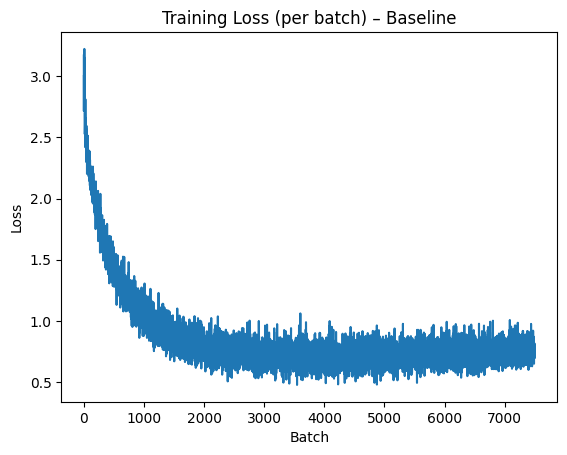

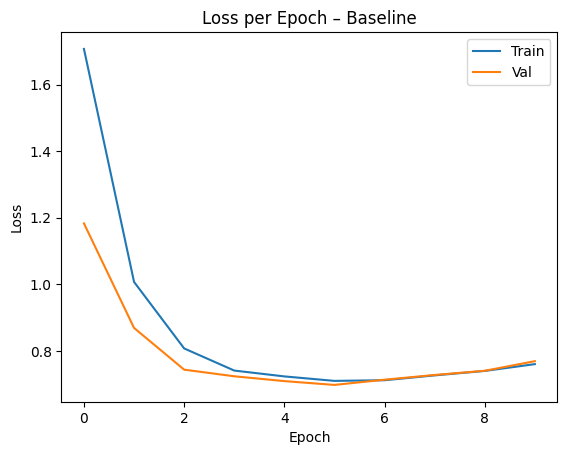

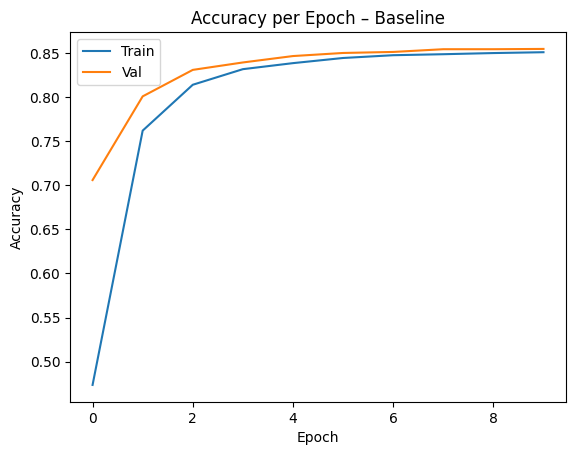

In [52]:
net_baseline = Net()
net_baseline.add(Linear(n_features, n_classes, device=device))

history_baseline, batch_losses_baseline = train_model(net_baseline, "Baseline – Linear(784→10)")

plt.figure(); plt.plot(np.array(batch_losses_baseline))
plt.xlabel('Batch'); plt.ylabel('Loss'); plt.title('Training Loss (per batch) – Baseline'); plt.show()

plt.figure()
plt.plot(history_baseline["train_loss"], label='Train')
plt.plot(history_baseline["val_loss"],   label='Val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss per Epoch – Baseline'); plt.show()

plt.figure()
plt.plot(history_baseline["train_acc"], label='Train')
plt.plot(history_baseline["val_acc"],   label='Val')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy per Epoch – Baseline'); plt.show()

#### Architecture A
``Linear → ReLU → Linear``


  Architecture A – Linear → ReLU → Linear


Epoch 1/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 226.35it/s]


Epoch 1/10 | lr=0.05000 | Train Loss: 1.5900  Acc: 0.5251 | Val Loss: 1.0723  Acc: 0.7303


Epoch 2/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 231.02it/s]


Epoch 2/10 | lr=0.05000 | Train Loss: 0.9191  Acc: 0.7827 | Val Loss: 0.8059  Acc: 0.8149


Epoch 3/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 229.42it/s]


Epoch 3/10 | lr=0.05000 | Train Loss: 0.7546  Acc: 0.8278 | Val Loss: 0.7070  Acc: 0.8402


Epoch 4/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 221.11it/s]


Epoch 4/10 | lr=0.02500 | Train Loss: 0.7149  Acc: 0.8428 | Val Loss: 0.7166  Acc: 0.8468


Epoch 5/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 226.39it/s]


Epoch 5/10 | lr=0.02500 | Train Loss: 0.7252  Acc: 0.8477 | Val Loss: 0.7281  Acc: 0.8490


Epoch 6/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 219.23it/s]


Epoch 6/10 | lr=0.02500 | Train Loss: 0.7373  Acc: 0.8515 | Val Loss: 0.7409  Acc: 0.8514


Epoch 7/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 218.92it/s]


Epoch 7/10 | lr=0.01250 | Train Loss: 0.7698  Acc: 0.8525 | Val Loss: 0.7930  Acc: 0.8514


Epoch 8/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 225.65it/s]


Epoch 8/10 | lr=0.01250 | Train Loss: 0.8212  Acc: 0.8514 | Val Loss: 0.8434  Acc: 0.8508


Epoch 9/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 216.54it/s]


Epoch 9/10 | lr=0.01250 | Train Loss: 0.8702  Acc: 0.8506 | Val Loss: 0.8908  Acc: 0.8494


Epoch 10/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 207.25it/s]


Epoch 10/10 | lr=0.00625 | Train Loss: 0.9320  Acc: 0.8494 | Val Loss: 0.9674  Acc: 0.8467


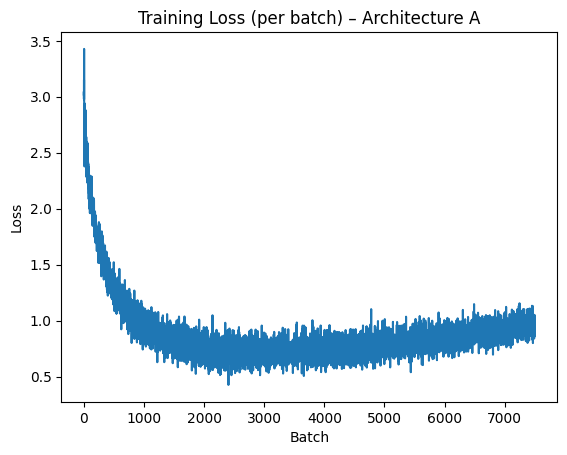

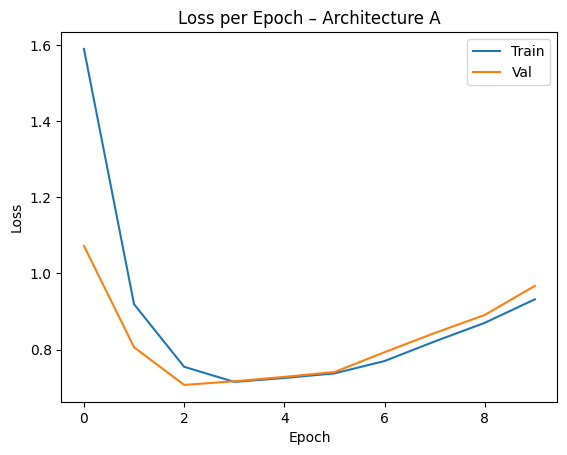

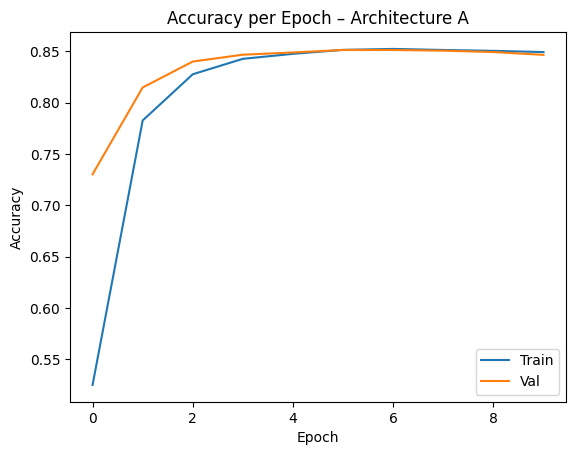

In [53]:
net_A = Net()
net_A.add(Linear(n_features, 256, device=device))
net_A.add(ReLU())
net_A.add(Linear(256, n_classes, device=device))

history_A, batch_losses_A = train_model(net_A, "Architecture A – Linear → ReLU → Linear")

plt.figure(); plt.plot(np.array(batch_losses_A))
plt.xlabel('Batch'); plt.ylabel('Loss'); plt.title('Training Loss (per batch) – Architecture A'); plt.show()

plt.figure()
plt.plot(history_A["train_loss"], label='Train')
plt.plot(history_A["val_loss"],   label='Val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss per Epoch – Architecture A'); plt.show()

plt.figure()
plt.plot(history_A["train_acc"], label='Train')
plt.plot(history_A["val_acc"],   label='Val')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy per Epoch – Architecture A'); plt.show()

#### Architecture B: 
``Linear → BN → ReLU → Dropout → Linear``


  Architecture B – Linear → BN → ReLU → Dropout → Linear


Epoch 1/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 225.01it/s]


Epoch 1/10 | lr=0.05000 | Train Loss: 1.6859  Acc: 0.4607 | Val Loss: 0.9845  Acc: 0.7373


Epoch 2/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 221.24it/s]


Epoch 2/10 | lr=0.05000 | Train Loss: 0.8953  Acc: 0.7437 | Val Loss: 0.6796  Acc: 0.8233


Epoch 3/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 221.86it/s]


Epoch 3/10 | lr=0.05000 | Train Loss: 0.6897  Acc: 0.8067 | Val Loss: 0.5555  Acc: 0.8588


Epoch 4/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 221.53it/s]


Epoch 4/10 | lr=0.02500 | Train Loss: 0.6122  Acc: 0.8295 | Val Loss: 0.5305  Acc: 0.8678


Epoch 5/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 221.69it/s]


Epoch 5/10 | lr=0.02500 | Train Loss: 0.5833  Acc: 0.8425 | Val Loss: 0.5110  Acc: 0.8733


Epoch 6/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 224.93it/s]


Epoch 6/10 | lr=0.02500 | Train Loss: 0.5620  Acc: 0.8495 | Val Loss: 0.4938  Acc: 0.8788


Epoch 7/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 215.10it/s]


Epoch 7/10 | lr=0.01250 | Train Loss: 0.5520  Acc: 0.8558 | Val Loss: 0.4968  Acc: 0.8821


Epoch 8/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 218.19it/s]


Epoch 8/10 | lr=0.01250 | Train Loss: 0.5565  Acc: 0.8602 | Val Loss: 0.5008  Acc: 0.8840


Epoch 9/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 221.55it/s]


Epoch 9/10 | lr=0.01250 | Train Loss: 0.5571  Acc: 0.8631 | Val Loss: 0.5064  Acc: 0.8857


Epoch 10/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 219.26it/s]


Epoch 10/10 | lr=0.00625 | Train Loss: 0.5651  Acc: 0.8660 | Val Loss: 0.5251  Acc: 0.8871


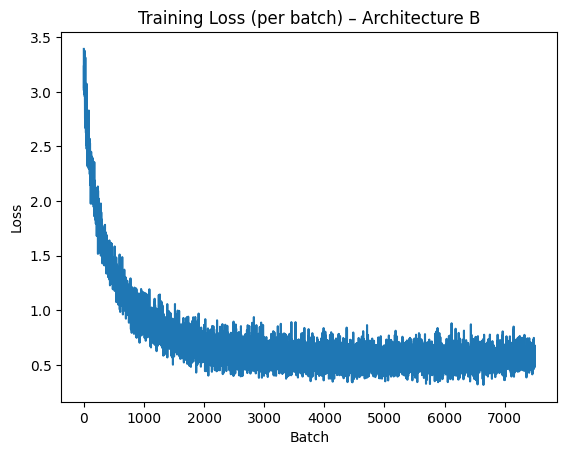

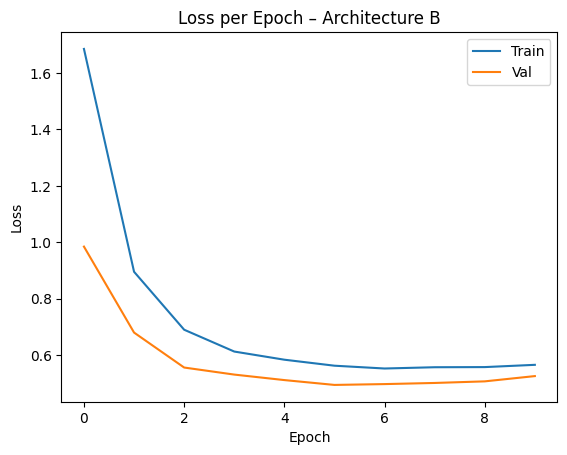

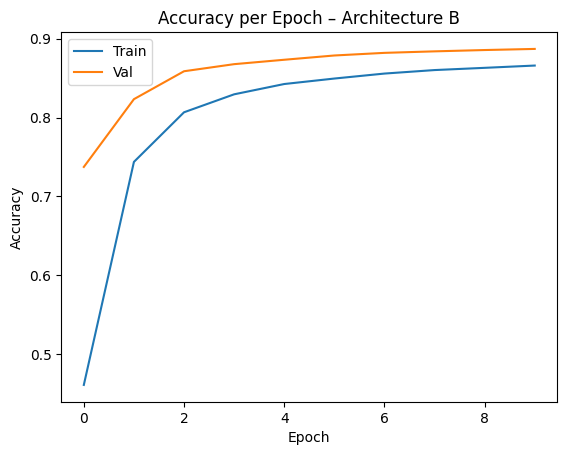

In [54]:
net_B = Net()
net_B.add(Linear(n_features, 256, device=device))
net_B.add(BatchNorm1D(256, device=device))
net_B.add(ReLU())
net_B.add(Dropout(p=0.2, device=device))
net_B.add(Linear(256, n_classes, device=device))

history_B, batch_losses_B = train_model(net_B, "Architecture B – Linear → BN → ReLU → Dropout → Linear")

plt.figure(); plt.plot(np.array(batch_losses_B))
plt.xlabel('Batch'); plt.ylabel('Loss'); plt.title('Training Loss (per batch) – Architecture B'); plt.show()

plt.figure()
plt.plot(history_B["train_loss"], label='Train')
plt.plot(history_B["val_loss"],   label='Val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss per Epoch – Architecture B'); plt.show()

plt.figure()
plt.plot(history_B["train_acc"], label='Train')
plt.plot(history_B["val_acc"],   label='Val')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy per Epoch – Architecture B'); plt.show()

#### Architecture C: 
``784→512→BN→ReLU→Drop→256→BN→ReLU→Drop→10``


  Architecture C – Deep MLP (BN + Dropout p=0.2)


Epoch 1/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 215.23it/s]


Epoch 1/10 | lr=0.05000 | Train Loss: 1.7112  Acc: 0.4423 | Val Loss: 0.9577  Acc: 0.7538


Epoch 2/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 191.96it/s]


Epoch 2/10 | lr=0.05000 | Train Loss: 0.9304  Acc: 0.7281 | Val Loss: 0.6350  Acc: 0.8373


Epoch 3/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 206.17it/s]


Epoch 3/10 | lr=0.05000 | Train Loss: 0.7057  Acc: 0.7989 | Val Loss: 0.5112  Acc: 0.8658


Epoch 4/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 208.61it/s]


Epoch 4/10 | lr=0.02500 | Train Loss: 0.6244  Acc: 0.8207 | Val Loss: 0.4857  Acc: 0.8759


Epoch 5/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 203.83it/s]


Epoch 5/10 | lr=0.02500 | Train Loss: 0.5907  Acc: 0.8341 | Val Loss: 0.4614  Acc: 0.8841


Epoch 6/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 207.83it/s]


Epoch 6/10 | lr=0.02500 | Train Loss: 0.5629  Acc: 0.8470 | Val Loss: 0.4390  Acc: 0.8909


Epoch 7/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 206.46it/s]


Epoch 7/10 | lr=0.01250 | Train Loss: 0.5507  Acc: 0.8512 | Val Loss: 0.4436  Acc: 0.8940


Epoch 8/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 207.53it/s]


Epoch 8/10 | lr=0.01250 | Train Loss: 0.5493  Acc: 0.8578 | Val Loss: 0.4490  Acc: 0.8959


Epoch 9/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 213.90it/s]


Epoch 9/10 | lr=0.01250 | Train Loss: 0.5487  Acc: 0.8609 | Val Loss: 0.4515  Acc: 0.8967


Epoch 10/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 213.11it/s]


Epoch 10/10 | lr=0.00625 | Train Loss: 0.5545  Acc: 0.8644 | Val Loss: 0.4653  Acc: 0.9004


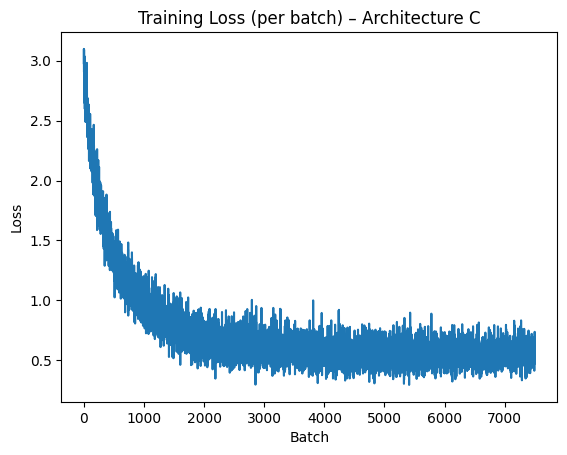

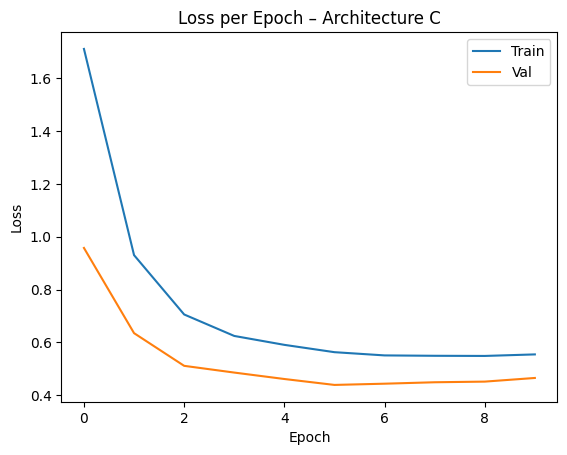

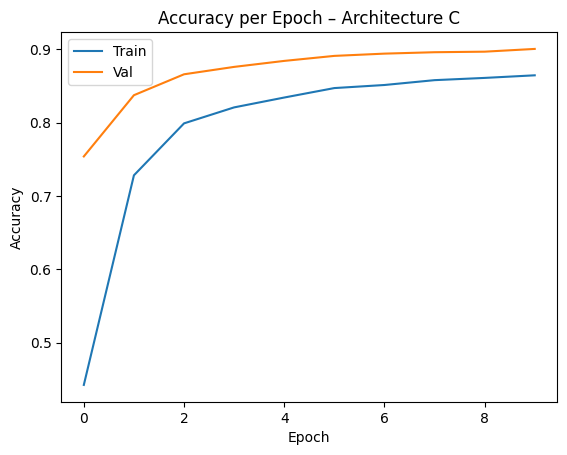

In [55]:
net_C = Net()
net_C.add(Linear(n_features, 512, device=device))
net_C.add(BatchNorm1D(512, device=device))
net_C.add(ReLU())
net_C.add(Dropout(p=0.2, device=device))
net_C.add(Linear(512, 256, device=device))
net_C.add(BatchNorm1D(256, device=device))
net_C.add(ReLU())
net_C.add(Dropout(p=0.2, device=device))
net_C.add(Linear(256, n_classes, device=device))

history_C, batch_losses_C = train_model(net_C, "Architecture C – Deep MLP (BN + Dropout p=0.2)")

plt.figure(); plt.plot(np.array(batch_losses_C))
plt.xlabel('Batch'); plt.ylabel('Loss'); plt.title('Training Loss (per batch) – Architecture C'); plt.show()

plt.figure()
plt.plot(history_C["train_loss"], label='Train')
plt.plot(history_C["val_loss"],   label='Val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss per Epoch – Architecture C'); plt.show()

plt.figure()
plt.plot(history_C["train_acc"], label='Train')
plt.plot(history_C["val_acc"],   label='Val')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy per Epoch – Architecture C'); plt.show()

#### Scenario D: 
Dropout Comparison using the **Scenario C** with diferente dropout probabilities  $ \ p \in \{ 0.0,  0.1,  0.5\}$


  Dropout Comparison – p=0.0


Epoch 1/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 210.87it/s]


Epoch 1/10 | lr=0.05000 | Train Loss: 1.3520  Acc: 0.5982 | Val Loss: 0.7743  Acc: 0.7987


Epoch 2/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 205.58it/s]


Epoch 2/10 | lr=0.05000 | Train Loss: 0.6565  Acc: 0.8308 | Val Loss: 0.5267  Acc: 0.8618


Epoch 3/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 208.63it/s]


Epoch 3/10 | lr=0.05000 | Train Loss: 0.5014  Acc: 0.8684 | Val Loss: 0.4341  Acc: 0.8887


Epoch 4/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 203.28it/s]


Epoch 4/10 | lr=0.02500 | Train Loss: 0.4462  Acc: 0.8849 | Val Loss: 0.4147  Acc: 0.8962


Epoch 5/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 201.15it/s]


Epoch 5/10 | lr=0.02500 | Train Loss: 0.4265  Acc: 0.8902 | Val Loss: 0.3967  Acc: 0.9015


Epoch 6/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 208.12it/s]


Epoch 6/10 | lr=0.02500 | Train Loss: 0.4093  Acc: 0.8979 | Val Loss: 0.3776  Acc: 0.9083


Epoch 7/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 201.28it/s]


Epoch 7/10 | lr=0.01250 | Train Loss: 0.4037  Acc: 0.9014 | Val Loss: 0.3858  Acc: 0.9101


Epoch 8/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 203.56it/s]


Epoch 8/10 | lr=0.01250 | Train Loss: 0.4087  Acc: 0.9041 | Val Loss: 0.3918  Acc: 0.9111


Epoch 9/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 208.69it/s]


Epoch 9/10 | lr=0.01250 | Train Loss: 0.4121  Acc: 0.9062 | Val Loss: 0.3935  Acc: 0.9135


Epoch 10/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 213.11it/s]


Epoch 10/10 | lr=0.00625 | Train Loss: 0.4212  Acc: 0.9080 | Val Loss: 0.4082  Acc: 0.9110


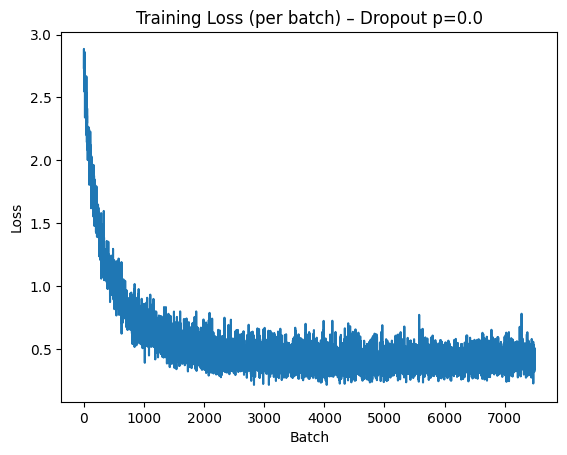

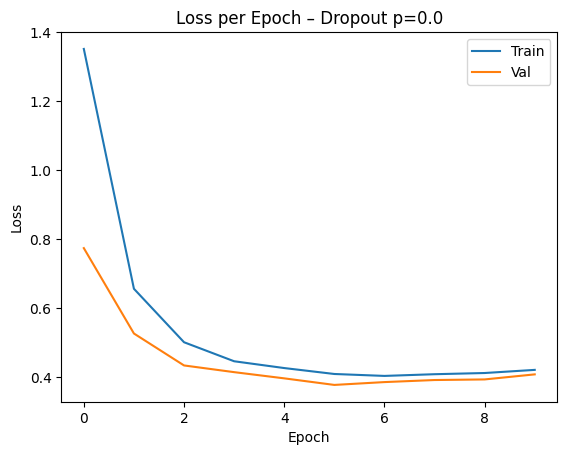

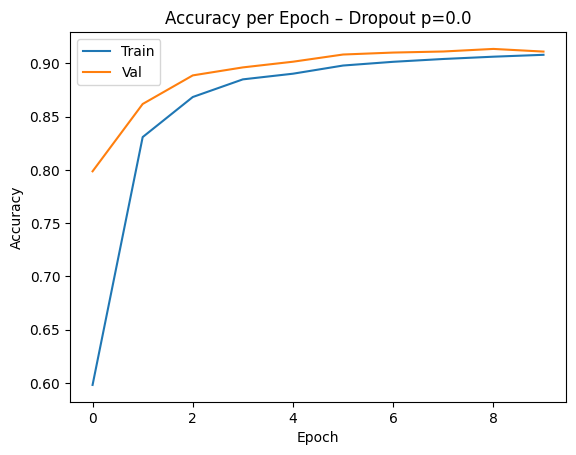


  Dropout Comparison – p=0.1


Epoch 1/10 [Val]: 100%|██████████| 188/188 [00:01<00:00, 186.56it/s]


Epoch 1/10 | lr=0.05000 | Train Loss: 1.4948  Acc: 0.5342 | Val Loss: 0.8332  Acc: 0.7888


Epoch 2/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 207.52it/s]


Epoch 2/10 | lr=0.05000 | Train Loss: 0.7649  Acc: 0.7894 | Val Loss: 0.5608  Acc: 0.8542


Epoch 3/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 202.11it/s]


Epoch 3/10 | lr=0.05000 | Train Loss: 0.5818  Acc: 0.8403 | Val Loss: 0.4554  Acc: 0.8818


Epoch 4/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 207.11it/s]


Epoch 4/10 | lr=0.02500 | Train Loss: 0.5196  Acc: 0.8595 | Val Loss: 0.4352  Acc: 0.8910


Epoch 5/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 208.10it/s]


Epoch 5/10 | lr=0.02500 | Train Loss: 0.4943  Acc: 0.8673 | Val Loss: 0.4181  Acc: 0.8955


Epoch 6/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 210.01it/s]


Epoch 6/10 | lr=0.02500 | Train Loss: 0.4751  Acc: 0.8752 | Val Loss: 0.3973  Acc: 0.9026


Epoch 7/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 202.69it/s]


Epoch 7/10 | lr=0.01250 | Train Loss: 0.4653  Acc: 0.8819 | Val Loss: 0.4061  Acc: 0.9017


Epoch 8/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 206.77it/s]


Epoch 8/10 | lr=0.01250 | Train Loss: 0.4695  Acc: 0.8839 | Val Loss: 0.4112  Acc: 0.9047


Epoch 9/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 204.36it/s]


Epoch 9/10 | lr=0.01250 | Train Loss: 0.4717  Acc: 0.8859 | Val Loss: 0.4095  Acc: 0.9067


Epoch 10/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 212.95it/s]


Epoch 10/10 | lr=0.00625 | Train Loss: 0.4787  Acc: 0.8885 | Val Loss: 0.4266  Acc: 0.9073


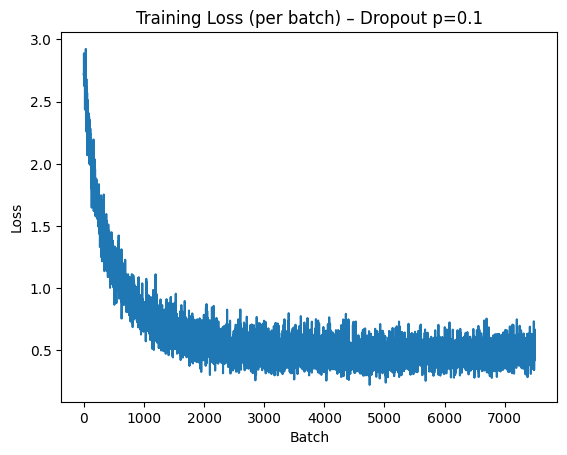

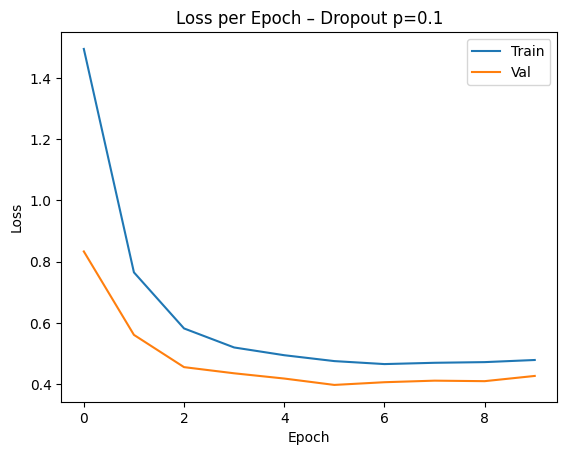

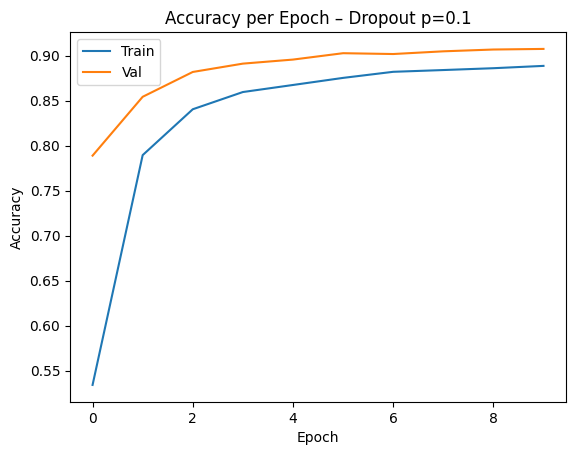


  Dropout Comparison – p=0.5


Epoch 1/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 209.37it/s]


Epoch 1/10 | lr=0.05000 | Train Loss: 2.2187  Acc: 0.2647 | Val Loss: 1.3322  Acc: 0.7021


Epoch 2/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 211.11it/s]


Epoch 2/10 | lr=0.05000 | Train Loss: 1.5001  Acc: 0.5008 | Val Loss: 0.9578  Acc: 0.7923


Epoch 3/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 215.51it/s]


Epoch 3/10 | lr=0.05000 | Train Loss: 1.1958  Acc: 0.6179 | Val Loss: 0.7506  Acc: 0.8279


Epoch 4/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 208.28it/s]


Epoch 4/10 | lr=0.02500 | Train Loss: 1.0545  Acc: 0.6685 | Val Loss: 0.7061  Acc: 0.8373


Epoch 5/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 204.09it/s]


Epoch 5/10 | lr=0.02500 | Train Loss: 0.9855  Acc: 0.6955 | Val Loss: 0.6677  Acc: 0.8448


Epoch 6/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 211.59it/s]


Epoch 6/10 | lr=0.02500 | Train Loss: 0.9326  Acc: 0.7167 | Val Loss: 0.6203  Acc: 0.8574


Epoch 7/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 211.33it/s]


Epoch 7/10 | lr=0.01250 | Train Loss: 0.8924  Acc: 0.7360 | Val Loss: 0.6265  Acc: 0.8599


Epoch 8/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 209.26it/s]


Epoch 8/10 | lr=0.01250 | Train Loss: 0.8828  Acc: 0.7451 | Val Loss: 0.6277  Acc: 0.8641


Epoch 9/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 208.02it/s]


Epoch 9/10 | lr=0.01250 | Train Loss: 0.8680  Acc: 0.7548 | Val Loss: 0.6205  Acc: 0.8663


Epoch 10/10 [Val]: 100%|██████████| 188/188 [00:00<00:00, 207.30it/s]


Epoch 10/10 | lr=0.00625 | Train Loss: 0.8666  Acc: 0.7585 | Val Loss: 0.6427  Acc: 0.8658


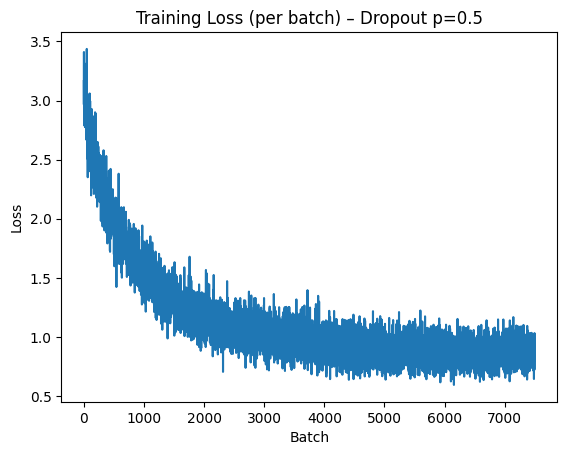

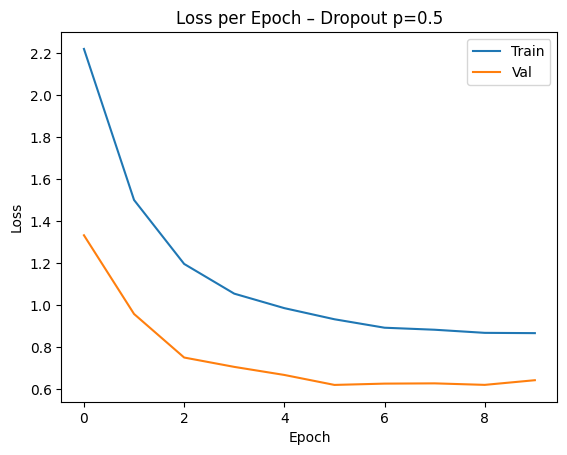

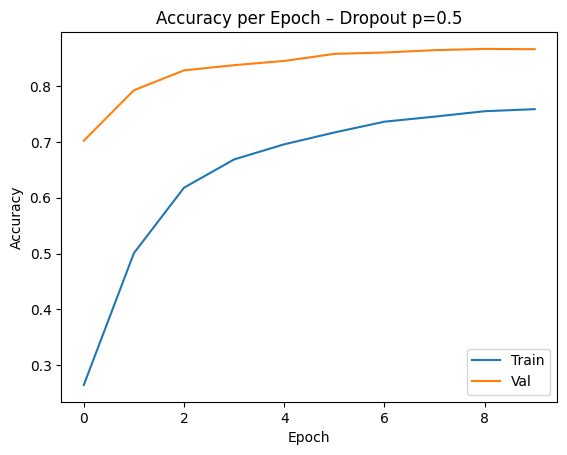

In [56]:
dropout_results = {}

for p in [0.0, 0.1, 0.5]:
    torch.manual_seed(42)

    net_d = Net()
    net_d.add(Linear(n_features, 512, device=device))
    net_d.add(BatchNorm1D(512, device=device))
    net_d.add(ReLU())
    net_d.add(Dropout(p=p, device=device))
    net_d.add(Linear(512, 256, device=device))
    net_d.add(BatchNorm1D(256, device=device))
    net_d.add(ReLU())
    net_d.add(Dropout(p=p, device=device))
    net_d.add(Linear(256, n_classes, device=device))

    history_p, batch_losses_p = train_model(net_d, f"Dropout Comparison – p={p}")

    plt.figure(); plt.plot(np.array(batch_losses_p))
    plt.xlabel('Batch'); plt.ylabel('Loss'); plt.title(f'Training Loss (per batch) – Dropout p={p}'); plt.show()

    plt.figure()
    plt.plot(history_p["train_loss"], label='Train')
    plt.plot(history_p["val_loss"],   label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title(f'Loss per Epoch – Dropout p={p}'); plt.show()

    plt.figure()
    plt.plot(history_p["train_acc"], label='Train')
    plt.plot(history_p["val_acc"],   label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title(f'Accuracy per Epoch – Dropout p={p}'); plt.show()

    dropout_results[p] = (net_d, history_p, batch_losses_p)

#### Final Comparison & Summary Table

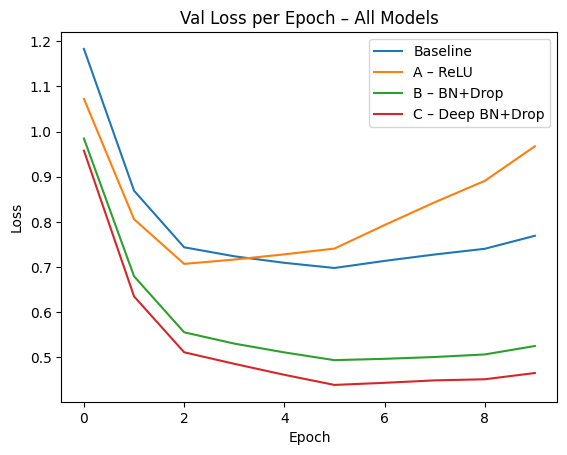

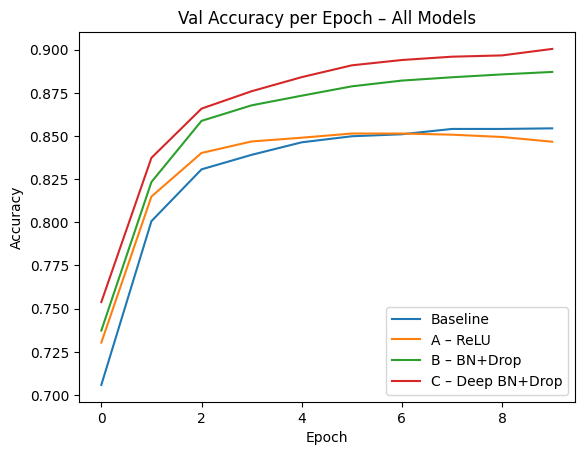

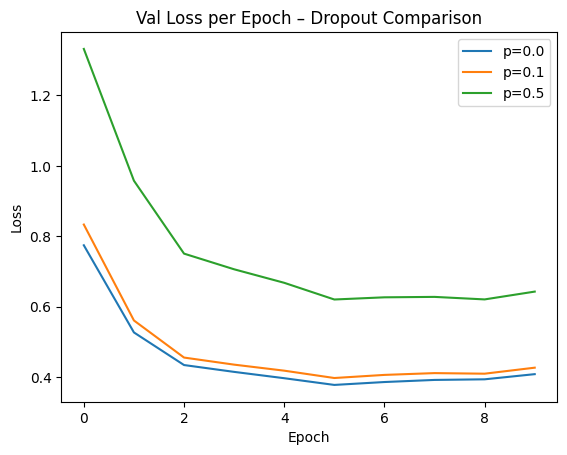

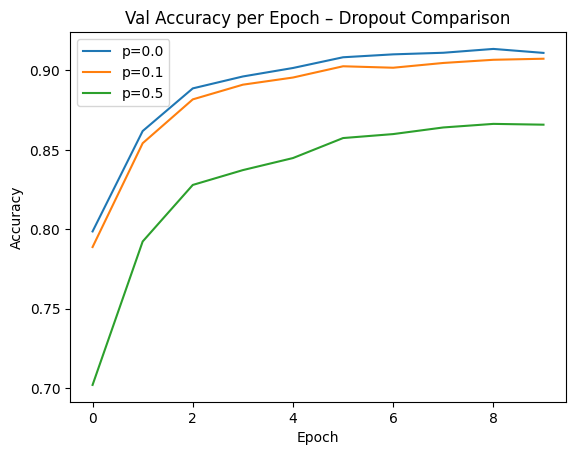


───────────────────────────────────────────────────────
Model                                  Best Val Acc
───────────────────────────────────────────────────────
Baseline – Linear(784→10)                    0.8544
A – Linear → ReLU → Linear                   0.8514
B – Linear → BN → ReLU → Drop                0.8871
C – Deep MLP  p=0.2                          0.9004
D – Deep MLP  Drop p=0.0                     0.9135
D – Deep MLP  Drop p=0.1                     0.9073
D – Deep MLP  Drop p=0.5                     0.8663
───────────────────────────────────────────────────────


In [57]:
plt.figure()
plt.plot(history_baseline["val_loss"], label='Baseline')
plt.plot(history_A["val_loss"],        label='A – ReLU')
plt.plot(history_B["val_loss"],        label='B – BN+Drop')
plt.plot(history_C["val_loss"],        label='C – Deep BN+Drop')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.title('Val Loss per Epoch – All Models'); plt.show()

plt.figure()
plt.plot(history_baseline["val_acc"], label='Baseline')
plt.plot(history_A["val_acc"],        label='A – ReLU')
plt.plot(history_B["val_acc"],        label='B – BN+Drop')
plt.plot(history_C["val_acc"],        label='C – Deep BN+Drop')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.title('Val Accuracy per Epoch – All Models'); plt.show()

plt.figure()
for p, (_, history_p, _) in dropout_results.items():
    plt.plot(history_p["val_loss"], label=f'p={p}')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.title('Val Loss per Epoch – Dropout Comparison'); plt.show()

plt.figure()
for p, (_, history_p, _) in dropout_results.items():
    plt.plot(history_p["val_acc"], label=f'p={p}')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.title('Val Accuracy per Epoch – Dropout Comparison'); plt.show()

print("\n" + "─" * 55)
print(f"{'Model':<38} {'Best Val Acc':>12}")
print("─" * 55)
for name, history in [
    ("Baseline – Linear(784→10)",       history_baseline),
    ("A – Linear → ReLU → Linear",      history_A),
    ("B – Linear → BN → ReLU → Drop",   history_B),
    ("C – Deep MLP  p=0.2",             history_C),
    ("D – Deep MLP  Drop p=0.0",        dropout_results[0.0][1]),
    ("D – Deep MLP  Drop p=0.1",        dropout_results[0.1][1]),
    ("D – Deep MLP  Drop p=0.5",        dropout_results[0.5][1]),
]:
    best = max(history["val_acc"])
    print(f"{name:<38} {best:>12.4f}")
print("─" * 55)

## <span style="color: lightgreen;">Explicación del mejor modelo</span>
La mejor arquitectura encontrada fue la C (Deep MLP con BatchNorm) usando Dropout desactivado.

La red neuronal es completamente conectada (MLP) profunda de 3 capas lineales, compuesta por:

- Capa de entrada: 784 características (imágenes MNIST)

- Primera capa oculta: 512 neuronas

- Segunda capa oculta: 256 neuronas

Cada bloque oculto sigue la siguiente secuencia de operaciones:

Capa lineal → Batch Normalization → ReLU → Dropout

En el modelo seleccionado, el Dropout se mantuvo con probabilidad p = 0 (es decir, sin desactivación de neuronas), pero se conserva en la arquitectura para mantener la misma estructura evaluada en los experimentos.

#### **Hiperparámetros del mejor experimento**

learning_rate = 0.05

weight_decay = 1e-4

num_epochs = 10

Semilla fija: torch.manual_seed(42) (mismo split train/val en todas las corridas)

#### **Accuracy en validación y test**

Train accuracy final (Epoch 10): 0.9061
Validation accuracy final (Epoch 10): 0.9152

Esto indica que, en el rango entrenado, el modelo mantuvo un desempeño alto en validación sin evidenciar deterioro hacia el final.

Test accuracy (evaluación final): 0.9211

### **Análisis de convergencia**

Evolución del rendimiento:

En los primeros 3 epochs, el modelo mejora de forma marcada: el val accuracy sube de 0.8048 → 0.8648 → 0.8883, mientras el val loss baja de 0.7739 → 0.5255 → 0.4286. Esto es consistente con un régimen inicial con lr=0.05, donde se aprende rápidamente una representación útil.

A partir del epoch 4, se activa la reducción de tasa de aprendizaje, y el entrenamiento entra en una fase de ajuste fino: el val accuracy continúa subiendo, pero con incrementos más pequeños (0.8974 → 0.9031 → 0.9081), mientras el val loss sigue descendiendo (0.4100 → 0.3934 → 0.3781).

En los epochs 7 a 10, el lr vuelve a reducirse (0.0125 y luego 0.00625). En esta etapa el val accuracy se estabiliza cerca de su máximo (0.9097 → 0.9114 → 0.9119 → 0.9152) y el val loss deja de bajar de forma monótona (sube ligeramente en el último epoch: 0.3893 → 0.4029).

Estabilidad y generalización:

El modelo termina con Train Accuracy = 0.9061 y Val Accuracy = 0.9152. La brecha es pequeña y no hay caída en validación, lo cual sugiere que no hubo sobreajuste en 10 epochs.

El hecho de que el mejor resultado ocurra en el último epoch indica que, con este schedule, el entrenamiento seguía mejorando (o al menos no se degradaba) hasta el final.

### **Comparación entre arquitecturas**

A continuación se comparan las arquitecturas con base en su mejor accuracy de validación (misma semilla y mismo protocolo de entrenamiento):

- Baseline – Linear(784→10): 0.8542
Modelo lineal simple. Alcanza un desempeño decente, pero queda por debajo de arquitecturas con mayor capacidad y normalización.

- Arquitectura A – Linear → ReLU → Linear: 0.8551
Añadir una capa oculta con ReLU mejora marginalmente respecto al baseline. Esto sugiere que, bajo estos hiperparámetros y número de epochs, el beneficio de “solo profundidad” sin técnicas de estabilización es limitado.

- Arquitectura B – Linear → BatchNorm → ReLU → Dropout → Linear: 0.8910
La introducción de BatchNorm (y un bloque con regularización) ofrece una mejora clara sobre Baseline y la arquitectura A. En general, BN ayuda a estabilizar la distribución interna y facilita la optimización, lo cual se refleja en una ganancia importante en validación.

- Arquitectura C – Deep MLP con BN + Dropout p = p
Aumentar la profundidad (dos bloques ocultos con BN) eleva aún más el desempeño. 

- Arquitectura D (misma estructura profunda, comparación de Dropout):

p=0.0: 0.9152 (mejor modelo)

p=0.2: 0.9032

p=0.5: 0.8720

##### **Conclusión comparativa:**
La mejor estrategia en estos experimentos fue combinar mayor profundidad + BatchNorm, y mantener Dropout desactivado (p=0.0). En este escenario, BatchNorm aporta estabilidad suficiente y el Dropout tiende a degradar el rendimiento al introducir demasiada regularización para el régimen de entrenamiento usado.

In [58]:
# ════════════════════════════════════════════════════════════════════
#  TEST ACCURACY  –  Run this cell AFTER the final task cell
#
#  1. Look at the summary table printed above.
#  2. Replace `best_net` with whichever model had the highest val acc.
#     Options:
#       net_baseline, net_A, net_B, net_C
#       or for dropout comparison: the net trained with the best p
#       
# Particular Case: Model C with p = 0.0 was best, set:
#       best_net = net_C
#
# ════════════════════════════════════════════════════════════════════

# ── Set your best model here ─────────────────────────────────────────
best_net = dropout_results[0.0][0]  # <-- change this to whichever model won

# ── Run on test set ──────────────────────────────────────────────────
best_net.eval()
CELoss = CrossEntropyFromLogits()

test_running_loss, test_correct, test_samples = 0.0, 0, 0

with torch.no_grad():
    for images, labels in tqdm(testloader, desc="[Test]"):
        X = images.view(images.size(0), -1).to(device)
        Y = labels.to(device)

        Z     = best_net.forward(X)
        vloss = CELoss.forward(Z, Y)
        test_running_loss += vloss.item()

        _, predicted = torch.max(Z, 1)
        test_correct  += (predicted == Y).sum().item()
        test_samples  += Y.size(0)

test_loss = test_running_loss / len(testloader)
test_acc  = test_correct      / test_samples

print(f"Test Loss: {test_loss:.4f}  |  Test Accuracy: {test_acc:.4f}")

[Test]: 100%|██████████| 157/157 [00:00<00:00, 195.85it/s]

Test Loss: 0.3849  |  Test Accuracy: 0.9195
